In [ ]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set Up Database Connection
# Replace the placeholders with your actual database credentials
DB_CONFIG = {
    "dbname": "csgo_parsed",
    "user": "csgo_parser",
    "password": "3?6B7yTGPrkJF34p",
    "host": "192.168.1.100",
    "port": "5444"
}

#TODO: check the descriptive_statistics_v2 for the improved sql query!

In [25]:


# Ensure we have a fresh connection
try:
    conn = psycopg2.connect(**DB_CONFIG)
    print("✅ Database connection established")
except Exception as e:
    print(f"❌ Connection error: {e}")

def get_descriptive_stats(data, column_name):
    """Calculate comprehensive descriptive statistics"""
    stats_dict = {
        'count': len(data),
        'min': data.min(),
        'max': data.max(),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'q25': data.quantile(0.25),
        'q75': data.quantile(0.75)
    }
    return stats_dict

def get_top_values(data, n=15):
    """Get top N occurring values with percentages"""
    value_counts = data.value_counts().head(n)
    percentages = (value_counts / len(data) * 100).round(2)
    return pd.DataFrame({
        'value': value_counts.index,
        'count': value_counts.values,
        'percentage': percentages.values
    })

def create_distribution_plots(data, title, bins=50):
    """Create histogram and box plot for a variable"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    ax1.hist(data.dropna(), bins=bins, alpha=0.7, edgecolor='black')
    ax1.set_title(f'{title} - Distribution')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2.boxplot(data.dropna())
    ax2.set_title(f'{title} - Box Plot')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("📊 Helper functions defined successfully!")

✅ Database connection established
📊 Helper functions defined successfully!


# Step 1: Calculate CSF r-value for Equipment

We'll calculate the Contest Success Function (CSF) r-value using equipment values from both teams. The CSF formula is:

$$P(\text{CT win}) = \frac{x^r}{x^r + y^r}$$

Where:
- $x$ = CT equipment value
- $y$ = T equipment value
- $r$ = parameter we estimate using Maximum Likelihood Estimation (MLE)

In [26]:
from scipy.optimize import minimize_scalar

# Query to get equipment values for both teams per round
query = """
SELECT 
    r.id,
	r.match_id,
    r.id_demo_exports,
	r.round_num,
    r.ct_winner,
    r.team1_winner,
    r.is_ct_t1,
    r.round_end_reason,
    dps.event_id,
    -- CT team equipment
    SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
    -- T team equipment
    SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment,
    -- Higher and lower equipment
    CASE 
        WHEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) > 
             SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        THEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        ELSE SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
    END as higher_equipment,
    CASE 
        WHEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) <= 
             SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        THEN SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
        ELSE SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END)
    END as lower_equipment,
    -- Did the higher equipment team win?
    CASE 
        WHEN (SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) > 
              SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) AND r.ct_winner)
        OR (SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) < 
            SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) AND NOT r.ct_winner)
        THEN 1
        ELSE 0
    END as higher_eq_won
FROM rounds_ed r
LEFT JOIN demo_processing_status dps ON r.id_demo_exports = dps.id
JOIN player_round_ed pr ON r.id = pr.round_id 
WHERE pr.eq_val_fte > 0  -- Valid equipment values
GROUP BY 1,2,3,4,5,6,7,8,9
HAVING SUM(CASE WHEN pr.team = 1 THEN pr.eq_val_fte ELSE 0 END) > 0
   AND SUM(CASE WHEN pr.team = 2 THEN pr.eq_val_fte ELSE 0 END) > 0
ORDER BY 1,2,3,4
"""

print("📊 Fetching equipment data from database...")
equipment_df = pd.read_sql_query(query, conn)
print(f"✅ Loaded {len(equipment_df):,} rounds")
print(f"   Matches: {equipment_df['match_id'].nunique():,}")
print(f"   Demos: {equipment_df['id_demo_exports'].nunique():,}")
print(f"   Tournament: {equipment_df['event_id'].nunique():,}")
print()


print("Data summary:")
print(equipment_df.describe())

📊 Fetching equipment data from database...


C:\Users\peter\AppData\Local\Temp\ipykernel_4264\1787897236.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  equipment_df = pd.read_sql_query(query, conn)


✅ Loaded 2,601,592 rounds
   Matches: 53,582
   Demos: 98,937
   Tournament: 3,831

Data summary:
                 id      match_id  id_demo_exports     round_num  \
count  2.601592e+06  2.601592e+06     2.601592e+06  2.601592e+06   
mean   1.307781e+06  2.337941e+06     9.658141e+04  1.414977e+01   
std    7.521266e+05  1.846523e+04     6.099380e+04  8.527394e+00   
min    5.891000e+03  2.292524e+06     1.000000e+00  1.000000e+00   
25%    6.565178e+05  2.323053e+06     4.355000e+04  7.000000e+00   
50%    1.307418e+06  2.340662e+06     9.537200e+04  1.400000e+01   
75%    1.958074e+06  2.353635e+06     1.415460e+05  2.000000e+01   
max    2.612227e+06  2.367066e+06     2.428270e+05  7.800000e+01   

       round_end_reason      event_id  ct_equipment   t_equipment  \
count      2.601592e+06  1.576996e+06  2.601592e+06  2.601592e+06   
mean       7.219965e+00  4.796741e+03  2.142590e+04  1.945296e+04   
std        2.824941e+00  1.740865e+03  1.055534e+04  8.944960e+03   
min        1.

In [27]:
# Define CSF log-likelihood function for MLE
def csf_log_likelihood(r, x, y, actual_wins):
    """
    Calculate negative log-likelihood for CSF model
    
    Parameters:
    - r: CSF parameter
    - x: CT equipment values
    - y: T equipment values
    - actual_wins: 1 if CT won, 0 otherwise
    """
    # Avoid division by zero and numerical issues
    r = max(r, 0.01)
    
    # Calculate predicted probabilities
    x_r = np.power(x, r)
    y_r = np.power(y, r)
    predicted_prob = x_r / (x_r + y_r)
    
    # Clip probabilities to avoid log(0)
    predicted_prob = np.clip(predicted_prob, 1e-10, 1 - 1e-10)
    
    # Calculate log-likelihood
    log_likelihood = np.sum(
        actual_wins * np.log(predicted_prob) + 
        (1 - actual_wins) * np.log(1 - predicted_prob)
    )
    
    # Return negative (for minimization)
    return -log_likelihood

# Estimate r-value using MLE
print("="*80)
print("🎯 CALCULATING CSF r-VALUE")
print("="*80)
print()

result = minimize_scalar(
    lambda r: csf_log_likelihood(r, 
                                equipment_df['ct_equipment'].values,
                                equipment_df['t_equipment'].values,
                                equipment_df['ct_winner'].values),
    bounds=(0.01, 10),
    method='bounded'
)

csf_r_value = result.x

print(f"✅ Optimal r-value: {csf_r_value:.4f}")
print()
print(f"📊 Model Performance:")
print(f"   CT win rate: {equipment_df['ct_winner'].mean():.2%}")
print(f"   Log-likelihood: {-result.fun:.2f}")
print()

# --- Estimation Uncertainty for r (Standard Error & 95% CI) ---
# Numerical second derivative (observed information) of negative log-likelihood at r_hat
def _second_derivative(fun, r, h=None):
    if h is None:
        h = 1e-5 * max(1.0, abs(r))
    return (fun(r + h) - 2.0 * fun(r) + fun(r - h)) / (h ** 2)

neglog_fun = lambda rr: csf_log_likelihood(rr,
                                          equipment_df['ct_equipment'].values,
                                          equipment_df['t_equipment'].values,
                                          equipment_df['ct_winner'].astype(int).values)
fpp = _second_derivative(neglog_fun, csf_r_value)

if fpp > 0:
    r_var = 1.0 / fpp
    r_se = np.sqrt(r_var)
else:
    r_var = np.nan
    r_se = np.nan

z = 1.96  # 95% normal approx
if not np.isnan(r_se):
    ci_wald_low = max(0.0, csf_r_value - z * r_se)
    ci_wald_high = csf_r_value + z * r_se
else:
    ci_wald_low = np.nan
    ci_wald_high = np.nan

print("📐 Uncertainty (Wald approximation):")
print(f"   f''(r̂) ≈ {fpp:.6g}")
print(f"   Var(r̂) ≈ {r_var:.6g} | SE(r̂) ≈ {r_se:.6g}")
print(f"   95% Wald CI: ({ci_wald_low:.6f}, {ci_wald_high:.6f})")
print()

# Optional: simple profile-likelihood CI (inversion of LRT) for robustness
from scipy.optimize import brentq
chi2_95 = stats.chi2.ppf(0.95, df=1)
threshold = result.fun + 0.5 * chi2_95  # target neg log-likelihood value

def target(rr):
    return neglog_fun(rr) - threshold

pl_lower, pl_upper = np.nan, np.nan
try:
    if neglog_fun(0.01) <= threshold:
        pl_lower = 0.01
    else:
        pl_lower = brentq(target, 0.01, max(0.01, csf_r_value))
except Exception:
    pass
try:
    if neglog_fun(10.0) <= threshold:
        pl_upper = 10.0
    else:
        if csf_r_value < 10.0:
            pl_upper = brentq(target, csf_r_value, 10.0)
except Exception:
    pass

print("🔍 Profile-likelihood 95% CI (approx):")
print(f"   ({pl_lower}, {pl_upper})")
print()

# Calculate predicted CT win probability with optimal r
equipment_df['predicted_win_prob'] = (
    np.power(equipment_df['ct_equipment'], csf_r_value) / 
    (np.power(equipment_df['ct_equipment'], csf_r_value) + 
     np.power(equipment_df['t_equipment'], csf_r_value))
)





🎯 CALCULATING CSF r-VALUE

✅ Optimal r-value: 1.0855

📊 Model Performance:
   CT win rate: 51.49%
   Log-likelihood: -1514257.48

📐 Uncertainty (Wald approximation):
   f''(r̂) ≈ 282084
   Var(r̂) ≈ 3.54505e-06 | SE(r̂) ≈ 0.00188283
   95% Wald CI: (1.081814, 1.089194)

🔍 Profile-likelihood 95% CI (approx):
   (1.0818174736238781, 1.0891985840757028)



In [28]:
# --- CSF Prediction Accuracy Analysis ---

print("="*80)
print("🔎 CSF PREDICTION ACCURACY ANALYSIS")
print("="*80)

# The CSF model predicts CT win probability for each round.
# Let's check how often the CSF prediction matches the actual round outcome.

# If predicted CT win probability > 0.5, CSF predicts CT win; else T win.
equipment_df['csf_predicted_winner'] = equipment_df['predicted_win_prob'] > 0.5

# Compare to actual outcome
equipment_df['csf_correct'] = equipment_df['csf_predicted_winner'] == equipment_df['ct_winner']

# Calculate accuracy
csf_accuracy = equipment_df['csf_correct'].mean()
total_rounds = len(equipment_df)
correct_rounds = equipment_df['csf_correct'].sum()

print(f"CSF correctly predicted the round winner in {correct_rounds:,} out of {total_rounds:,} rounds.")
print(f"Average CSF prediction accuracy: {csf_accuracy:.2%}")
print("="*80)

🔎 CSF PREDICTION ACCURACY ANALYSIS
CSF correctly predicted the round winner in 1,709,361 out of 2,601,592 rounds.
Average CSF prediction accuracy: 65.70%


🔎 CSF PREDICTION ACCURACY ANALYSIS (1% BINS WITH CI)

📊 OVERALL ACCURACY:
CSF correctly predicted the round winner in 1,709,361 out of 2,601,592 rounds.
Average CSF prediction accuracy: 65.70%

📊 ACCURACY BY 1% CSF PROBABILITY BINS (WITH SE & 95% CI)

Bin                 N   % Total   Accuracy       SE               95% CI   CT Win %       SE               95% CI   AvgProb
------------------------------------------------------------------------------------------------------------------------
2-3%           14,390      0.55%     96.19%     0.16% [ 95.88%,  96.50%]      3.81%     0.16% [  3.50%,   4.12%]     2.79%
3-4%           33,891      1.30%     96.88%     0.09% [ 96.69%,  97.06%]      3.12%     0.09% [  2.94%,   3.31%]     3.53%
4-5%           30,589      1.18%     95.78%     0.11% [ 95.55%,  96.00%]      4.22%     0.11% [  4.00%,   4.45%]     4.46%
5-6%           21,408      0.82%     94.70%     0.15% [ 94.40%,  95.00%]      5.30%     0.15% [  5.00%,   5.60%]     5.49%
6-6%       

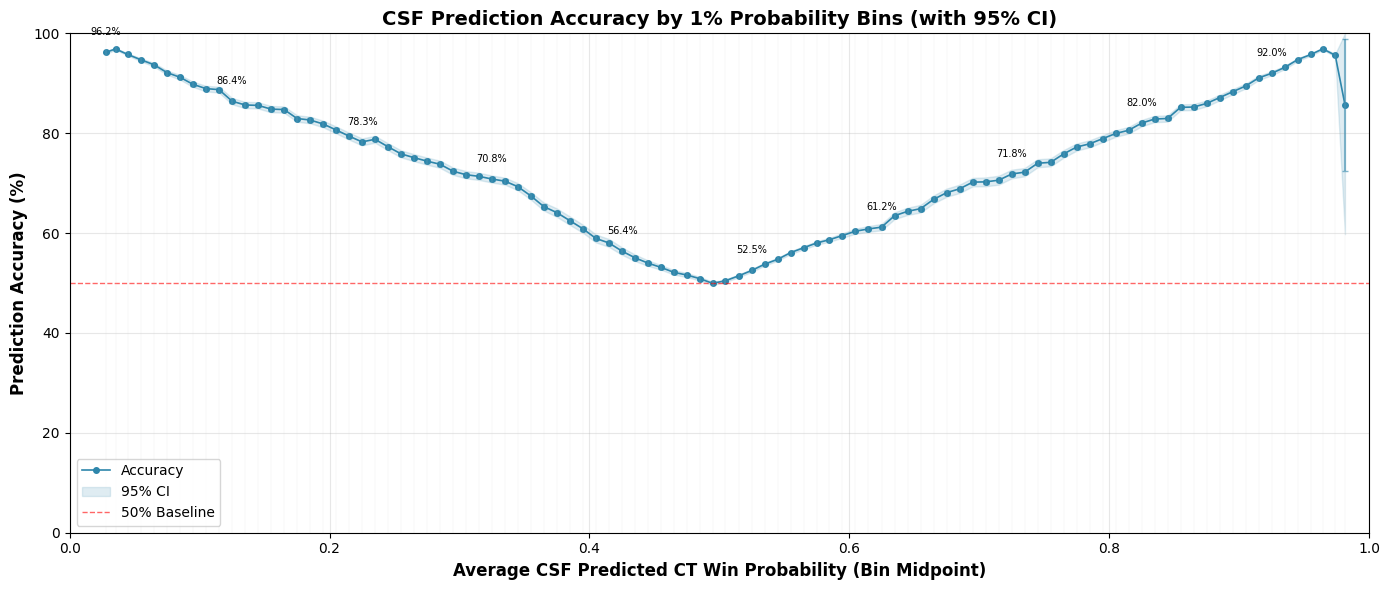


📊 GRAPH 2: CALIBRATION (1% BINS) WITH 95% CI


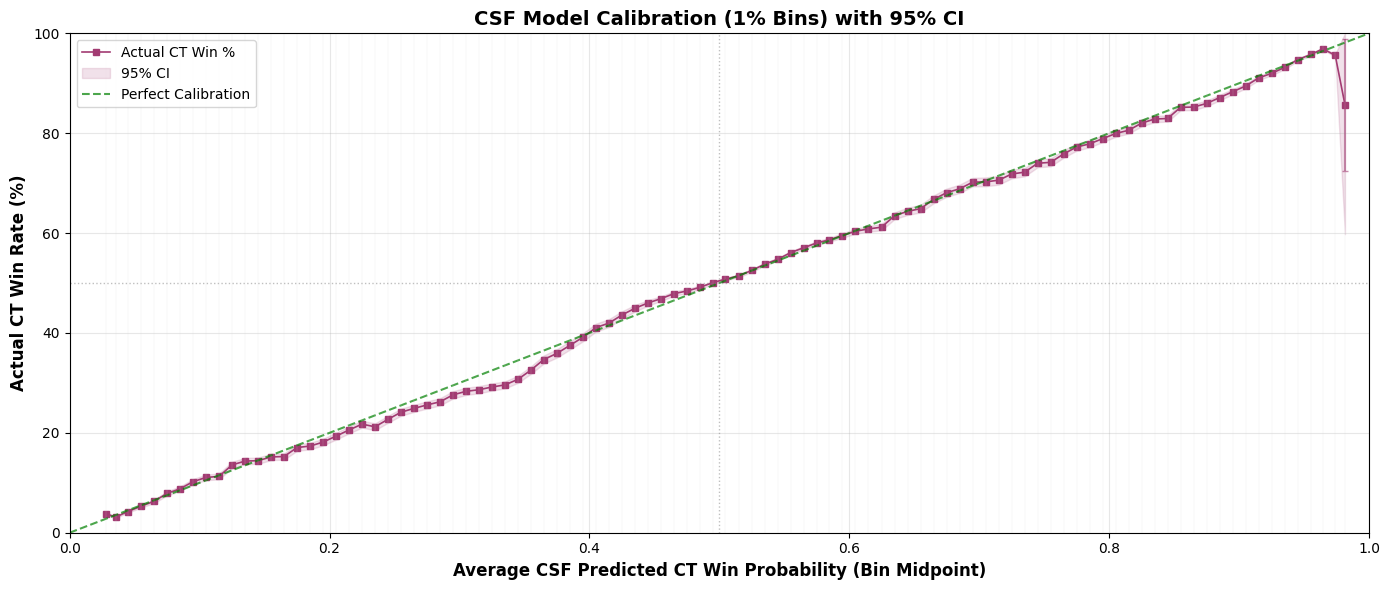


📊 GRAPH 3: ROUND DISTRIBUTION (1% BINS)


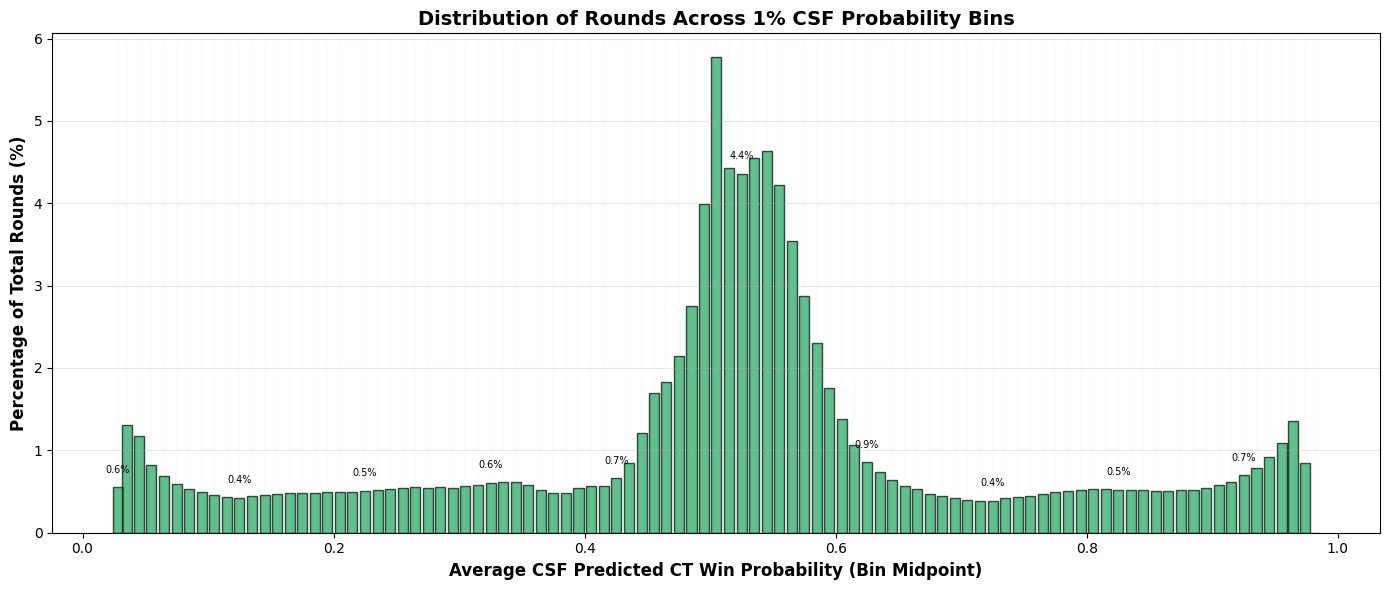


✓ 1% bin CSF analysis complete with SE and 95% CI plotted!
  Total rounds analyzed: 2,601,592
  Overall accuracy: 65.70%


In [29]:
# --- CSF Prediction Accuracy Analysis (1% Bins with SE & 95% CI) ---

print("="*80)
print("🔎 CSF PREDICTION ACCURACY ANALYSIS (1% BINS WITH CI)")
print("="*80)
print()

# Binary prediction (threshold 0.5)
equipment_df['csf_predicted_winner'] = equipment_df['predicted_win_prob'] > 0.5
equipment_df['csf_correct'] = equipment_df['csf_predicted_winner'] == equipment_df['ct_winner']

# Overall accuracy
csf_accuracy = equipment_df['csf_correct'].mean()
total_rounds = len(equipment_df)
correct_rounds = equipment_df['csf_correct'].sum()
print(f"📊 OVERALL ACCURACY:")
print(f"CSF correctly predicted the round winner in {correct_rounds:,} out of {total_rounds:,} rounds.")
print(f"Average CSF prediction accuracy: {csf_accuracy:.2%}")
print()

# Create 1% bins
bins_1pct = np.arange(0, 1.01, 0.01)  # 0.00, 0.01, ..., 1.00
bin_labels = [f"{int(i*100)}-{int((i+0.01)*100)}%" for i in bins_1pct[:-1]]

# Assign bins
equipment_df['csf_bin_1pct'] = pd.cut(
    equipment_df['predicted_win_prob'],
    bins=bins_1pct,
    labels=bin_labels,
    include_lowest=True,
    right=False  # left-inclusive intervals [i, i+0.01)
)

# Stats per bin including SE and 95% CI
z95 = 1.96
bin_stats = []
print("="*80)
print("📊 ACCURACY BY 1% CSF PROBABILITY BINS (WITH SE & 95% CI)")
print("="*80)
print()
print(f"{'Bin':<12} {'N':>8} {'% Total':>9} {'Accuracy':>10} {'SE':>8} {'95% CI':>20} {'CT Win %':>10} {'SE':>8} {'95% CI':>20} {'AvgProb':>9}")
print("-"*120)
for i, bin_label in enumerate(bin_labels):
    df_bin = equipment_df[equipment_df['csf_bin_1pct'] == bin_label]
    if len(df_bin) == 0:
        continue
    n_rounds = len(df_bin)
    pct_of_total = n_rounds / total_rounds * 100

    # Accuracy (binary): mean of csf_correct
    acc = df_bin['csf_correct'].mean()
    # Standard error for proportion
    se_acc = np.sqrt(acc * (1 - acc) / n_rounds) if n_rounds > 0 else np.nan
    ci_acc_low = max(0.0, acc - z95 * se_acc)
    ci_acc_high = min(1.0, acc + z95 * se_acc)

    # CT win rate (binary): mean of ct_winner
    ct_win = df_bin['ct_winner'].mean()
    se_ct = np.sqrt(ct_win * (1 - ct_win) / n_rounds) if n_rounds > 0 else np.nan
    ci_ct_low = max(0.0, ct_win - z95 * se_ct)
    ci_ct_high = min(1.0, ct_win + z95 * se_ct)

    avg_prob = df_bin['predicted_win_prob'].mean()

    bin_stats.append({
        'bin': bin_label,
        'n_rounds': n_rounds,
        'pct_of_total': pct_of_total,
        'accuracy': acc,
        'se_acc': se_acc,
        'ci_acc_low': ci_acc_low,
        'ci_acc_high': ci_acc_high,
        'ct_win_rate': ct_win,
        'se_ct': se_ct,
        'ci_ct_low': ci_ct_low,
        'ci_ct_high': ci_ct_high,
        'avg_prob': avg_prob
    })

    print(f"{bin_label:<12} {n_rounds:8,} {pct_of_total:9.2f}% {acc*100:9.2f}% {se_acc*100:8.2f}% [{ci_acc_low*100:6.2f}%, {ci_acc_high*100:6.2f}%] {ct_win*100:9.2f}% {se_ct*100:8.2f}% [{ci_ct_low*100:6.2f}%, {ci_ct_high*100:6.2f}%] {avg_prob*100:8.2f}%")

print()

# Extract plotting data
plot_probs = np.array([s['avg_prob'] for s in bin_stats])
plot_accuracy = np.array([s['accuracy'] * 100 for s in bin_stats])
plot_se_acc = np.array([s['se_acc'] * 100 for s in bin_stats])
plot_ci_low_acc = np.array([s['ci_acc_low'] * 100 for s in bin_stats])
plot_ci_high_acc = np.array([s['ci_acc_high'] * 100 for s in bin_stats])

plot_ct_win = np.array([s['ct_win_rate'] * 100 for s in bin_stats])
plot_se_ct = np.array([s['se_ct'] * 100 for s in bin_stats])
plot_ci_low_ct = np.array([s['ci_ct_low'] * 100 for s in bin_stats])
plot_ci_high_ct = np.array([s['ci_ct_high'] * 100 for s in bin_stats])

plot_pct_total = np.array([s['pct_of_total'] for s in bin_stats])

# GRAPH 1: Accuracy vs average predicted probability (1% bins) with 95% CI band
print("="*80)
print("📈 GRAPH 1: PREDICTION ACCURACY (1% BINS) WITH 95% CI")
print("="*80)
fig1, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(plot_probs, plot_accuracy, marker='o', linewidth=1.2, markersize=4, color='#2E86AB', label='Accuracy')
# CI band
ax1.fill_between(plot_probs, plot_ci_low_acc, plot_ci_high_acc, color='#2E86AB', alpha=0.15, label='95% CI')
# Error bars (thin)
ax1.errorbar(plot_probs, plot_accuracy, yerr=plot_se_acc, fmt='none', ecolor='#2E86AB', alpha=0.6, capsize=2)
ax1.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.6, label='50% Baseline')
# Vertical bin lines
for x in plot_probs:
    ax1.axvline(x, color='lightgray', linewidth=0.35, alpha=0.35)

ax1.set_xlabel('Average CSF Predicted CT Win Probability (Bin Midpoint)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Prediction Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('CSF Prediction Accuracy by 1% Probability Bins (with 95% CI)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0,1])
ax1.set_ylim([0,100])
ax1.legend(fontsize=10)
# sparse point labels
for x,y in zip(plot_probs[::10], plot_accuracy[::10]):
    ax1.text(x, min(y+3,100), f"{y:.1f}%", ha='center', va='bottom', fontsize=7)
plt.tight_layout()
plt.show()
print()

# GRAPH 2: Calibration (Actual CT win rate vs predicted probability) with 95% CI
print("="*80)
print("📊 GRAPH 2: CALIBRATION (1% BINS) WITH 95% CI")
print("="*80)
fig2, ax2 = plt.subplots(figsize=(14,6))
ax2.plot(plot_probs, plot_ct_win, marker='s', linewidth=1.2, markersize=4, color='#A23B72', label='Actual CT Win %')
# CI band for CT win rate
ax2.fill_between(plot_probs, plot_ci_low_ct, plot_ci_high_ct, color='#A23B72', alpha=0.15, label='95% CI')
ax2.errorbar(plot_probs, plot_ct_win, yerr=plot_se_ct, fmt='none', ecolor='#A23B72', alpha=0.6, capsize=2)
ax2.plot([0,1],[0,100], color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Perfect Calibration')
ax2.axhline(y=50, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax2.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
# Vertical bin lines
for x in plot_probs:
    ax2.axvline(x, color='lightgray', linewidth=0.35, alpha=0.35)

ax2.set_xlabel('Average CSF Predicted CT Win Probability (Bin Midpoint)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Actual CT Win Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('CSF Model Calibration (1% Bins) with 95% CI', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0,1])
ax2.set_ylim([0,100])
ax2.legend(fontsize=10)
plt.tight_layout()
plt.show()
print()

# GRAPH 3: Distribution of rounds across 1% bins (same as before)
print("="*80)
print("📊 GRAPH 3: ROUND DISTRIBUTION (1% BINS)")
print("="*80)
fig3, ax3 = plt.subplots(figsize=(14,6))
ax3.bar(plot_probs, plot_pct_total, width=0.008, color='#18A558', alpha=0.7, edgecolor='black')
# Add vertical lines for each bin midpoint
for x in plot_probs:
    ax3.axvline(x, color='lightgray', linewidth=0.35, alpha=0.25)
ax3.set_xlabel('Average CSF Predicted CT Win Probability (Bin Midpoint)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Percentage of Total Rounds (%)', fontsize=12, fontweight='bold')
ax3.set_title('Distribution of Rounds Across 1% CSF Probability Bins', fontsize=14, fontweight='bold')
ax3.grid(True, axis='y', alpha=0.3)
# annotate sparsely
for x,y in zip(plot_probs[::10], plot_pct_total[::10]):
    ax3.text(x, y+0.15, f"{y:.1f}%", ha='center', va='bottom', fontsize=7)
plt.tight_layout()
plt.show()

print()
print("="*80)
print("✓ 1% bin CSF analysis complete with SE and 95% CI plotted!")
print(f"  Total rounds analyzed: {total_rounds:,}")
print(f"  Overall accuracy: {csf_accuracy:.2%}")
print("="*80)

# Step 2: Fetch Additional Round Data

Now we need to fetch data about:
1. **Round end reason** - How the round ended (elimination, bomb defused, time expired, etc.)
2. **Number of survivors** - How many players survived on the winning team
3. **Saved equipment** - Equipment value of survivors
4. **Money earned** - Money earned by teams

In [ ]:
# Query for detailed round outcomes
query_detailed = """
WITH round_equipment AS (
    SELECT 
        r.id,
        r.match_id,
        r.id_demo_exports,
        r.round_num,
        r.ct_winner,
        r.team1_winner,
        r.is_ct_t1,
        r.round_end_reason,
        dps.event_id,
        -- CT team equipment
        SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
        -- T team equipment
        SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment
    FROM rounds_ed r
    JOIN player_round_ed pr ON r.id = pr.round_id
    LEFT JOIN demo_processing_status dps ON r.id_demo_exports = dps.id
    WHERE pr.eq_val_fte > 0
    GROUP BY 1,2,3,4,5,6,7,8,9
),
bomb_planted AS (
    SELECT 
        round_id,
        CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END as bomb_planted
    FROM bomb_events_round_ed
    WHERE bomb_event_type = 0
    GROUP BY round_id
),
round_survivors AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- Count total players per team (5 players each)
        -- CT survivors = 5 - (deaths of CT players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 = (pv.team = 1)) THEN k.victim_hltv_id 
        END) as ct_survivors,
        -- T survivors = 5 - (deaths of T players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 != (pv.team = 1)) THEN k.victim_hltv_id 
        END) as t_survivors
    FROM rounds_ed r
    LEFT JOIN kills_round_ed k ON r.id = k.round_id
    LEFT JOIN player_round_ed pv ON k.victim_hltv_id = pv.player_id AND k.round_id = pv.round_id and pv.player_id != 0
    GROUP BY 1,2
),
saved_equipment AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as ct_saved_equipment,
        -- T team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as t_saved_equipment
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
    GROUP BY 1,2
),
player_money AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team player money (money_earned + money_earned_re) joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) 
            THEN COALESCE(pe.money_earned, 0)
            ELSE 0 END) as ct_player_money,
        -- T team player money (money_earned + money_earned_re) joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) 
            THEN COALESCE(pe.money_earned, 0)  
            ELSE 0 END) as t_player_money
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
    GROUP BY 1,2
)
SELECT 
    re.*,
    -- Add bomb planted status
    COALESCE(bp.bomb_planted, 0) as bomb_planted,
    -- Add survivor counts from round_survivors CTE
    rs.ct_survivors,
    rs.t_survivors,
    -- Higher and lower equipment
    CASE 
        WHEN re.ct_equipment > re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as higher_equipment,
    CASE 
        WHEN re.ct_equipment <= re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as lower_equipment,
    -- Did higher equipment team win?
    CASE 
        WHEN (re.ct_equipment > re.t_equipment AND re.ct_winner)
        OR (re.ct_equipment < re.t_equipment AND NOT re.ct_winner)
        THEN 1
        ELSE 0
    END as higher_eq_won,
    -- Winner's survivors (only from is_alive_re)
    CASE 
        WHEN re.ct_winner THEN rs.ct_survivors
        ELSE rs.t_survivors
    END as winner_survivors,
    -- Winner's saved equipment (from player_economy_ed.saved_eq_val)
    CASE 
        WHEN re.ct_winner THEN se.ct_saved_equipment
        ELSE se.t_saved_equipment
    END as winner_saved_equipment,
    -- CT and T saved equipment 
    se.ct_saved_equipment,
    se.t_saved_equipment,
    -- All money columns for analysis
    pm.ct_player_money,
    pm.t_player_money
FROM round_equipment re
LEFT JOIN bomb_planted bp ON re.id = bp.round_id
LEFT JOIN round_survivors rs ON re.id = rs.round_id
LEFT JOIN saved_equipment se ON re.id = se.round_id
LEFT JOIN player_money pm ON re.id = pm.round_id
WHERE re.ct_equipment > 0 AND re.t_equipment > 0 
ORDER BY re.match_id, re.round_num
"""

print("📊 Fetching detailed round data...")
detailed_df = pd.read_sql_query(query_detailed, conn)
print(f"✅ Loaded {len(detailed_df):,} rounds with complete data")
print()

# Combine round end reasons 12 and 7
print("🔹 Pre-processing: Combining round end reasons 12 and 7")
detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({12: 7})
print(f"   Round end reasons 12 merged into 7")
print()

# Recode round end reasons: 1→1, 9→2, 7→3, 8→4
print("🔹 Recoding round end reasons")
original_count = len(detailed_df)
print(f"   Original distribution:")
for old_code in [1, 7, 8, 9]:
    count = (detailed_df['round_end_reason'] == old_code).sum()
    pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
    print(f"      Reason {old_code}: {count:,} rounds ({pct:.2f}%)")

detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({
    1: 1,  # T Win (Target Bombed) - no change
    9: 2,  # T Win (Elimination) - 9 → 2
    7: 3,  # CT Win (Defuse) - 7 → 3
    8: 4,  # CT Win (Elimination) - 8 → 4
})

print(f"   New distribution:")
for new_code in [1, 2, 3, 4]:
    count = (detailed_df['round_end_reason'] == new_code).sum()
    pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
    print(f"      Reason {new_code}: {count:,} rounds ({pct:.2f}%)")
print()



# Calculate CSF predictions for this dataset (CT win probability)
detailed_df['predicted_win_prob'] = (
    np.power(detailed_df['ct_equipment'], csf_r_value) / 
    (np.power(detailed_df['ct_equipment'], csf_r_value) + 
     np.power(detailed_df['t_equipment'], csf_r_value))
)


📊 Fetching detailed round data...


C:\Users\peter\AppData\Local\Temp\ipykernel_4264\460099665.py:129: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  detailed_df = pd.read_sql_query(query_detailed, conn)


✅ Loaded 2,601,592 rounds with complete data

🔹 Pre-processing: Combining round end reasons 12 and 7
   Round end reasons 12 merged into 7

🔹 Recoding round end reasons
   Original distribution:
      Reason 1: 407,446 rounds (15.66%)
      Reason 7: 405,067 rounds (15.57%)
      Reason 8: 934,538 rounds (35.92%)
      Reason 9: 854,541 rounds (32.85%)
   New distribution:
      Reason 1: 407,446 rounds (15.66%)
      Reason 2: 854,541 rounds (32.85%)
      Reason 3: 405,067 rounds (15.57%)
      Reason 4: 934,538 rounds (35.92%)

demos: 98,937
matches: 53,582
tournaments: 3,831


In [43]:
print("="*80)
print("🔍 DATA QUALITY: FILTERING INCONSISTENT ROUNDS")
print("="*80)
print()

# Filter out inconsistent data
# Reason 2 (T Win Elimination - was 9) should have CT survivors = 0
filtered_9 = (detailed_df['round_end_reason'] == 2) & (detailed_df['ct_survivors'] > 0)
reason_9_issues = detailed_df[filtered_9]
print(f"🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:")
print(f"   Found {len(reason_9_issues):,} rounds where Reason 2 occurred but CT had survivors > 0")

before = len(detailed_df)
detailed_df = detailed_df[~filtered_9]
total_filtered = before - len(detailed_df)

print(f"   Removed: {total_filtered:,} rounds")
print(f"   Remaining: {len(detailed_df):,} rounds")
print()
print("✅ Data quality filtering complete")

print(f"demos: {detailed_df['id_demo_exports'].nunique():,}")
print(f"matches: {detailed_df['match_id'].nunique():,}")
print(f"tournaments: {detailed_df['event_id'].nunique():,}")


🔍 DATA QUALITY: FILTERING INCONSISTENT ROUNDS

🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:
   Found 0 rounds where Reason 2 occurred but CT had survivors > 0
   Removed: 0 rounds
   Remaining: 2,598,771 rounds

✅ Data quality filtering complete
demos: 98,937
matches: 53,582
tournaments: 3,831


# Round End Reason Prediction Model

We'll analyze how round end reasons vary with CSF advantage. This helps the ABM predict realistic round outcomes based on equipment advantage.

In [32]:
print("="*80)
print("📊 ROUND END REASON DISTRIBUTION BY CSF PERCENTAGE (CT & T SIDES)")
print("="*80)
print()

# Get top 4 round end reasons
top_reasons = detailed_df['round_end_reason'].value_counts().head(4).index.tolist()
reason_names = {
    1: "T Win (Target Bombed)",
    2: "T Win (Elimination)",
    3: "CT Win (Defuse)",
    4: "CT Win (Elimination)",
}

print("Top 4 Round End Reasons:")
for reason in top_reasons:
    reason_name = reason_names.get(reason, f"Reason {reason}")
    count = (detailed_df['round_end_reason'] == reason).sum()
    pct = count / len(detailed_df) * 100
    print(f"   {reason}: {reason_name} - {count:,} rounds ({pct:.2f}%)")
print()

# Create CSF percentage bins (0-100% in steps)
csf_bins = np.arange(0, 1.01, 0.01)  # 0%, 1%, 2%, ..., 100%
csf_labels = [f"{int(i*100)}" for i in csf_bins[:-1]]

detailed_df['csf_pct_bin'] = pd.cut(detailed_df['predicted_win_prob'], 
                                     bins=csf_bins, 
                                     labels=csf_labels,
                                     include_lowest=True,
                                     ordered=False)

# Analyze round end reason distributions by CSF percentage for CT and T sides
round_end_reason_analysis = {}

for side in ['CT', 'T']:
    print(f"\n{'='*80}")
    print(f"🔹 {side} SIDE ROUND END REASON DISTRIBUTIONS")
    print(f"{'='*80}\n")
    
    side_analysis = {}
    
    for csf_pct in range(1, 101):  # 1% to 100% CSF (CT win probability)
        df_csf = detailed_df[detailed_df['csf_pct_bin'] == str(csf_pct)].copy()
        
        if len(df_csf) < 10:
            continue
        
        # Determine which rounds this side won
        if side == 'CT':
            df_side = df_csf[df_csf['ct_winner'] == True].copy()
        else:
            df_side = df_csf[df_csf['ct_winner'] == False].copy()
        
        if len(df_side) < 5:
            continue
        
        # Calculate distribution of round end reasons for this side's wins
        reason_counts = df_side['round_end_reason'].value_counts()
        total_rounds = len(df_side)
        
        reason_dist = {}
        for reason in top_reasons:
            count = reason_counts.get(reason, 0)
            prob = count / total_rounds if total_rounds > 0 else 0
            reason_dist[reason] = {
                'count': int(count),
                'probability': float(prob),
                'reason_name': reason_names.get(reason, f"Reason {reason}")
            }
        
        side_analysis[csf_pct] = {
            'n_rounds': total_rounds,
            'reason_distribution': reason_dist
        }
    
    # Print sample at key CSF percentages
    print(f"{side} Round End Reason Distribution by CSF%:")
    print(f"{'CSF%':<6} {'N':<8} {'Reason 1':<12} {'Reason 2':<12} {'Reason 3':<12} {'Reason 4':<12}")
    print(f"{'-'*70}")
    
    for csf_pct in [10, 30, 50, 70, 90]:
        if csf_pct in side_analysis:
            data = side_analysis[csf_pct]
            reason_dist = data['reason_distribution']
            
            print(f"{csf_pct:<6} {data['n_rounds']:<8,} "
                  f"{reason_dist.get(1, {}).get('probability', 0):<12.4f} "
                  f"{reason_dist.get(2, {}).get('probability', 0):<12.4f} "
                  f"{reason_dist.get(3, {}).get('probability', 0):<12.4f} "
                  f"{reason_dist.get(4, {}).get('probability', 0):<12.4f}")
    
    round_end_reason_analysis[side] = side_analysis

print()
print("="*80)
print("✅ Round end reason distribution analysis complete")
print("="*80)
print()
print("💡 Use these distributions to sample round end reasons based on CSF advantage and side")


📊 ROUND END REASON DISTRIBUTION BY CSF PERCENTAGE (CT & T SIDES)

Top 4 Round End Reasons:
   4: CT Win (Elimination) - 934,538 rounds (35.96%)
   2: T Win (Elimination) - 851,720 rounds (32.77%)
   1: T Win (Target Bombed) - 407,446 rounds (15.68%)
   3: CT Win (Defuse) - 405,067 rounds (15.59%)


🔹 CT SIDE ROUND END REASON DISTRIBUTIONS

CT Round End Reason Distribution by CSF%:
CSF%   N        Reason 1     Reason 2     Reason 3     Reason 4    
----------------------------------------------------------------------
10     1,322    0.0000       0.0000       0.3298       0.6702      
30     4,152    0.0000       0.0000       0.3671       0.6329      
50     64,894   0.0000       0.0000       0.3783       0.6217      
70     7,184    0.0000       0.0000       0.2634       0.7366      
90     13,602   0.0000       0.0000       0.1553       0.8447      

🔹 T SIDE ROUND END REASON DISTRIBUTIONS

T Round End Reason Distribution by CSF%:
CSF%   N        Reason 1     Reason 2     Reason 3    

📊 Creating round end reason distribution visualization...



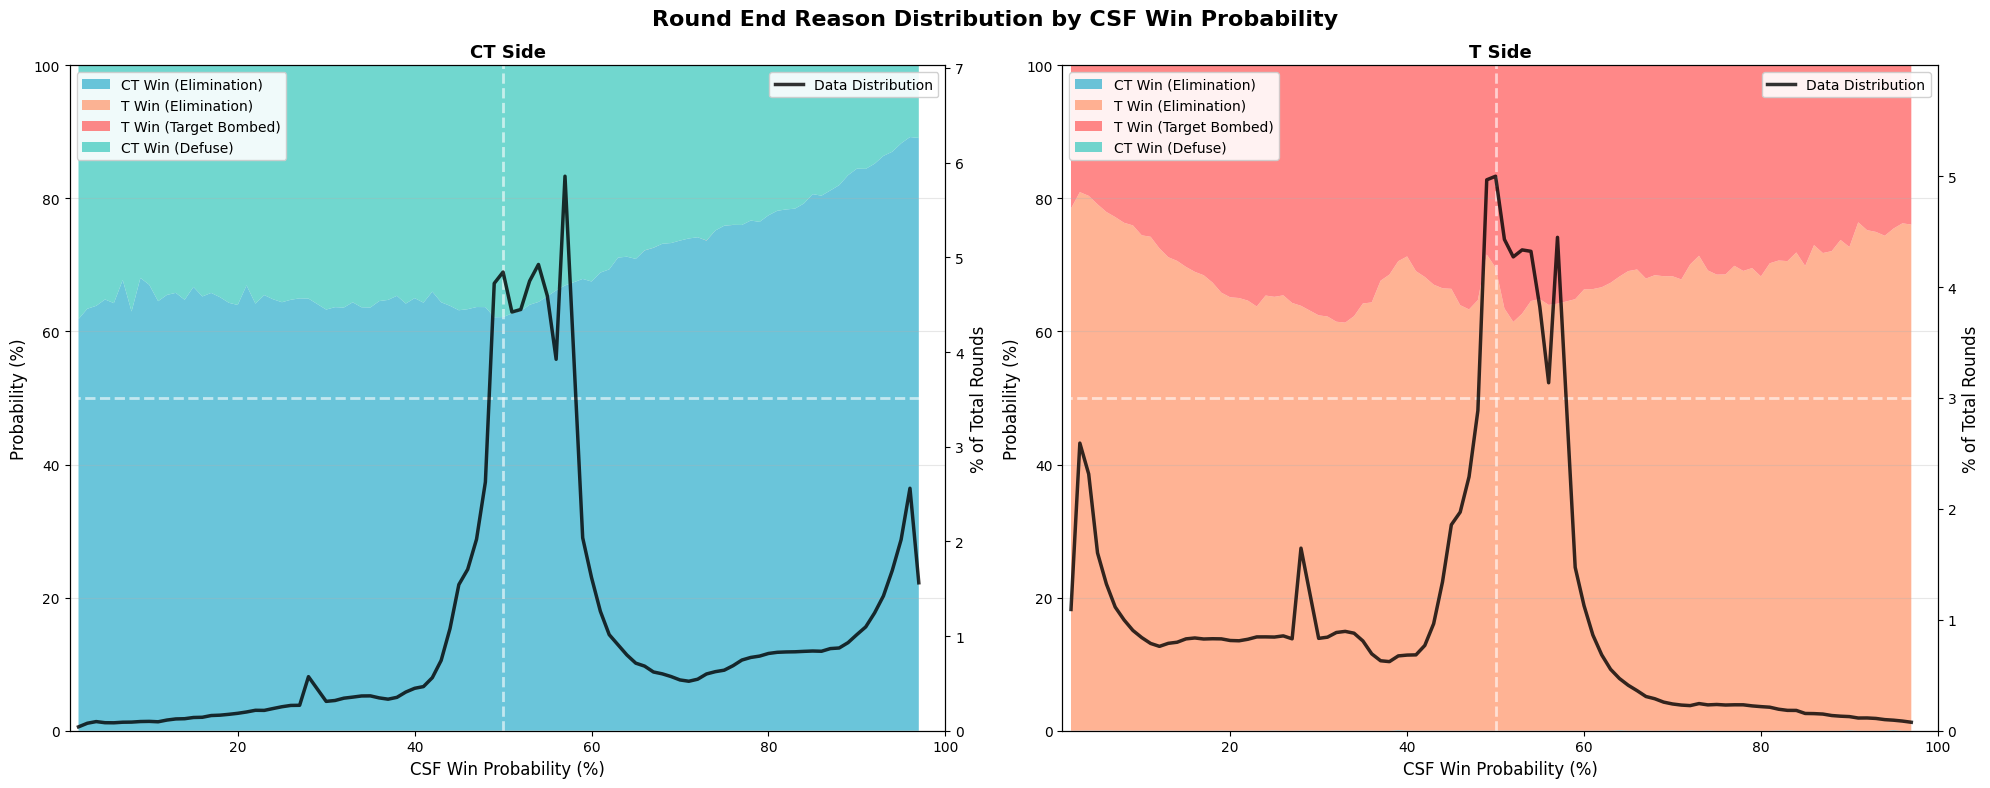

✅ Round end reason visualization complete!

💡 KEY INSIGHTS:
   CT SIDE:
   • When CT has equipment advantage, they win more by elimination (Reason 4)
   • Defuse/Time wins (Reason 3) represent successful defense

   T SIDE:
   • When T has equipment advantage, they win more by elimination (Reason 2)
   • Target Bombed (Reason 1) represents successful bomb detonation

   • Use these distributions in ABM to sample realistic round outcomes per side


In [33]:
# Visualize round end reason distributions with stacked area plots (CT and T sides)
print("📊 Creating round end reason distribution visualization...")
print()

# Create visualization for CT and T sides
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Round End Reason Distribution by CSF Win Probability', 
             fontsize=16, fontweight='bold')

# Define colors for each reason
colors = {
    1: '#FF6B6B',  # Red - Target Bombed (T Win)
    2: '#FFA07A',  # Orange - Elimination (T Win)
    3: '#4ECDC4',  # Cyan - Defuse/Time (CT Win)
    4: '#45B7D1',  # Blue - Elimination (CT Win)
}

for side_idx, side in enumerate(['CT', 'T']):
    ax = axes[side_idx]
    
    if side not in round_end_reason_analysis or not round_end_reason_analysis[side]:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
               transform=ax.transAxes, fontsize=14)
        ax.set_xlabel('CSF Win Probability (%)', fontsize=12)
        ax.set_ylabel('Probability (%)', fontsize=12)
        ax.set_title(f'{side} Side', fontsize=13, fontweight='bold')
        continue
    
    side_data = round_end_reason_analysis[side]
    
    # Prepare data for stacked area plot
    csf_percentages = sorted(side_data.keys())
    reason_probs = {reason: [] for reason in top_reasons}
    
    for csf_pct in csf_percentages:
        data = side_data[csf_pct]
        reason_dist = data['reason_distribution']
        
        for reason in top_reasons:
            prob = reason_dist.get(reason, {}).get('probability', 0) * 100
            reason_probs[reason].append(prob)
    
    # Stack the areas
    y_data = np.array([reason_probs[reason] for reason in top_reasons])
    labels = [reason_names.get(reason, f"Reason {reason}") for reason in top_reasons]
    color_list = [colors.get(reason, 'gray') for reason in top_reasons]
    
    ax.stackplot(csf_percentages, y_data, 
                labels=labels,
                colors=color_list, alpha=0.8)
    
    # Create secondary y-axis for data distribution percentage
    ax2 = ax.twinx()
    n_samples = [side_data[csf_pct]['n_rounds'] for csf_pct in csf_percentages]
    
    # Calculate total rounds in the entire dataset for this side
    total_rounds_this_side = sum(side_data[csf_pct]['n_rounds'] for csf_pct in csf_percentages)
    
    # Calculate percentage of total rounds at each CSF percentage
    percentages = [(n / total_rounds_this_side * 100) if total_rounds_this_side > 0 else 0 
                   for n in n_samples]
    
    ax2.plot(csf_percentages, percentages, color='black', linewidth=2.5, 
             label='Data Distribution', alpha=0.8, linestyle='-', marker='')
    ax2.set_ylabel('% of Total Rounds', fontsize=12, color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylim(0, max(percentages) * 1.2 if percentages else 10)  # Dynamic ylim based on data
    ax2.legend(loc='upper right', fontsize=10, framealpha=0.9)
    
    # Formatting
    ax.set_xlabel('CSF Win Probability (%)', fontsize=12)
    ax.set_ylabel('Probability (%)', fontsize=12)
    ax.set_title(f'{side} Side', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xlim(1, 100)
    ax.set_ylim(0, 100)
    
    # Add reference line at 50%
    ax.axhline(y=50, color='white', linestyle='--', alpha=0.6, linewidth=2)
    ax.axvline(x=50, color='white', linestyle='--', alpha=0.6, linewidth=2)

plt.tight_layout()
plt.show()

print("✅ Round end reason visualization complete!")
print()
print("💡 KEY INSIGHTS:")
print("   CT SIDE:")
print("   • When CT has equipment advantage, they win more by elimination (Reason 4)")
print("   • Defuse/Time wins (Reason 3) represent successful defense")
print()
print("   T SIDE:")
print("   • When T has equipment advantage, they win more by elimination (Reason 2)")
print("   • Target Bombed (Reason 1) represents successful bomb detonation")
print()
print("   • Use these distributions in ABM to sample realistic round outcomes per side")


In [34]:
print("="*80)
print("📊 BOMB PLANTED ANALYSIS BY CSF PERCENTAGE (CT & T SIDES)")
print("="*80)
print("   (Reason 2: T Elimination wins only)")
print()

# Analyze bomb planted rates by CSF percentage for CT and T sides
# Only look at reason 2 (T Win Elimination - was 9)
bomb_planted_analysis = {}

for side in ['T']:
    print(f"\n{'='*80}")
    print(f"🔹 {side} SIDE BOMB PLANTED RATES")
    print(f"{'='*80}\n")
    
    side_analysis = {}
    
    for csf_pct in range(1, 101):  # 1% to 100% CSF (CT win probability)
        df_csf = detailed_df[detailed_df['csf_pct_bin'] == str(csf_pct)].copy()
        
        if len(df_csf) < 10:
            continue
        
        # Determine which rounds this side won AND filter by elimination reasons only
        if side == 'T':
            # T wins by elimination (reason 2 - was 9)
            df_side = df_csf[(df_csf['ct_winner'] == False) & 
                            (df_csf['round_end_reason'] == 2)].copy()
        
        if len(df_side) < 5:
            continue
        
        # Calculate bomb planted statistics
        total_rounds = len(df_side)
        bomb_planted_count = df_side['bomb_planted'].sum()
        bomb_planted_prob = bomb_planted_count / total_rounds if total_rounds > 0 else 0
        
        side_analysis[csf_pct] = {
            'n_rounds': total_rounds,
            'bomb_planted_count': int(bomb_planted_count),
            'bomb_planted_probability': float(bomb_planted_prob),
            'bomb_not_planted_probability': float(1 - bomb_planted_prob)
        }
    
    # Print sample at key CSF percentages
    print(f"{side} Bomb Planted Rate by CSF%:")
    print(f"{'CSF%':<6} {'N':<8} {'Planted':<12} {'Not Planted':<12}")
    print(f"{'-'*50}")
    
    for csf_pct in [10, 30, 50, 70, 90]:
        if csf_pct in side_analysis:
            data = side_analysis[csf_pct]
            print(f"{csf_pct:<6} {data['n_rounds']:<8,} "
                  f"{data['bomb_planted_probability']:<12.4f} "
                  f"{data['bomb_not_planted_probability']:<12.4f}")
    
    bomb_planted_analysis[side] = side_analysis

print()
print("="*80)
print("✅ Bomb planted analysis complete (Reason 2 only)")
print("="*80)
print()
print("💡 Use these distributions to sample bomb planted probability for T elimination wins")


📊 BOMB PLANTED ANALYSIS BY CSF PERCENTAGE (CT & T SIDES)
   (Reason 2: T Elimination wins only)


🔹 T SIDE BOMB PLANTED RATES

T Bomb Planted Rate by CSF%:
CSF%   N        Planted      Not Planted 
--------------------------------------------------
10     7,870    0.6508       0.3492      
30     6,545    0.7273       0.2727      
50     43,812   0.8436       0.1564      
70     2,074    0.8293       0.1707      
90     1,165    0.8395       0.1605      

✅ Bomb planted analysis complete (Reason 2 only)

💡 Use these distributions to sample bomb planted probability for T elimination wins


📊 Creating bomb planted distribution visualization...



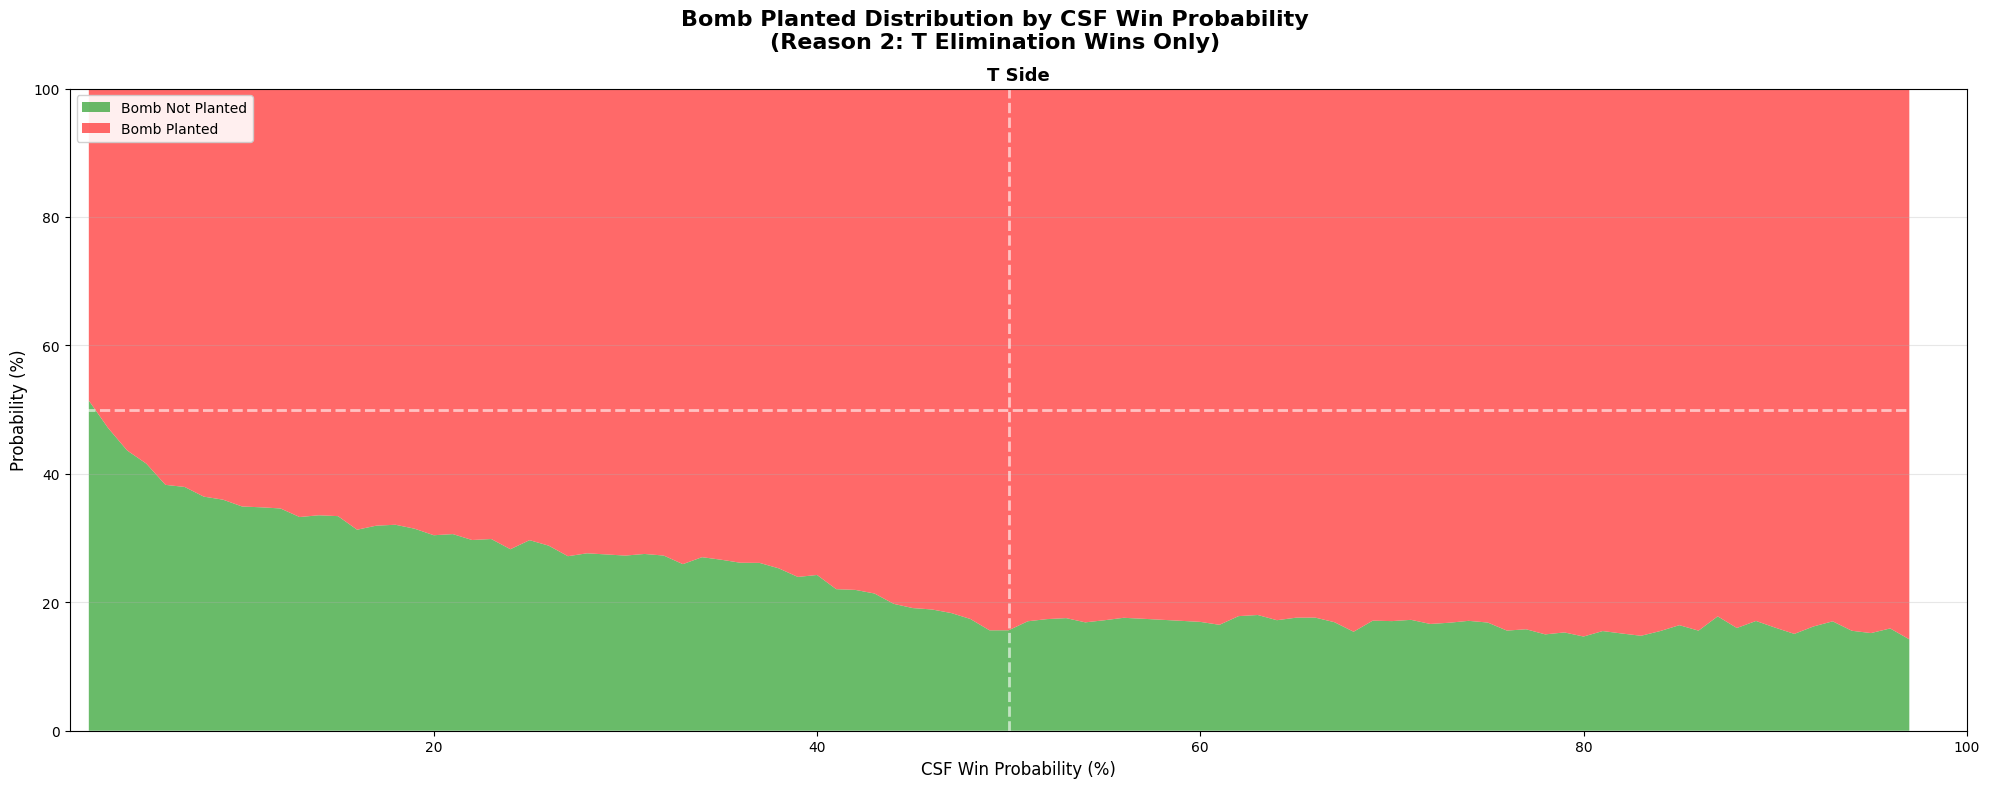

✅ Bomb planted visualization complete!

💡 KEY INSIGHTS:
   T SIDE (Reason 2 - T Win Elimination):
   • Shows bomb plant rate when T wins by elimination
   • Bomb planted means T planted then eliminated CT

   • Use these distributions in ABM for elimination round scenarios


In [35]:
# Visualize bomb planted distributions with stacked area plots (CT and T sides)
print("📊 Creating bomb planted distribution visualization...")
print()

# Create visualization for CT and T sides
fig, axes = plt.subplots(1, 1, figsize=(20, 8))
fig.suptitle('Bomb Planted Distribution by CSF Win Probability\n(Reason 2: T Elimination Wins Only)', 
             fontsize=16, fontweight='bold')

# Define colors
colors_bomb = {
    'planted': '#FF4444',      # Red - Bomb Planted
    'not_planted': '#44AA44',  # Green - Bomb Not Planted
}

for side_idx, side in enumerate(['T']):
    
    
    if side not in bomb_planted_analysis or not bomb_planted_analysis[side]:
        axes.text(0.5, 0.5, 'No Data', ha='center', va='center', 
               transform=axes.transAxes, fontsize=14)
        axes.set_xlabel('CSF Win Probability (%)', fontsize=12)
        axes.set_ylabel('Probability (%)', fontsize=12)
        axes.set_title(f'{side} Side', fontsize=13, fontweight='bold')
        continue
    
    side_data = bomb_planted_analysis[side]
    
    # Prepare data for stacked area plot
    csf_percentages = sorted(side_data.keys())
    planted_probs = []
    not_planted_probs = []
    
    for csf_pct in csf_percentages:
        data = side_data[csf_pct]
        planted_probs.append(data['bomb_planted_probability'] * 100)
        not_planted_probs.append(data['bomb_not_planted_probability'] * 100)
    
    # Stack the areas
    y_data = np.array([not_planted_probs, planted_probs])
    labels = ['Bomb Not Planted', 'Bomb Planted']
    color_list = [colors_bomb['not_planted'], colors_bomb['planted']]
    
    axes.stackplot(csf_percentages, y_data, 
                labels=labels,
                colors=color_list, alpha=0.8)
    
    # Formatting
    axes.set_xlabel('CSF Win Probability (%)', fontsize=12)
    axes.set_ylabel('Probability (%)', fontsize=12)
    axes.set_title(f'{side} Side', fontsize=13, fontweight='bold')
    axes.legend(loc='upper left', fontsize=10, framealpha=0.9)
    axes.grid(True, alpha=0.3, axis='y')
    axes.set_xlim(1, 100)
    axes.set_ylim(0, 100)
    
    # Add reference line at 50%
    axes.axhline(y=50, color='white', linestyle='--', alpha=0.6, linewidth=2)
    axes.axvline(x=50, color='white', linestyle='--', alpha=0.6, linewidth=2)

plt.tight_layout()
plt.show()

print("✅ Bomb planted visualization complete!")
print()
print("💡 KEY INSIGHTS:")
print("   T SIDE (Reason 2 - T Win Elimination):")
print("   • Shows bomb plant rate when T wins by elimination")
print("   • Bomb planted means T planted then eliminated CT")
print()
print("   • Use these distributions in ABM for elimination round scenarios")


# Survivor Prediction Model

We'll analyze the relationship between:
1. **CSF prediction** (win probability based on equipment advantage)
2. **Round end reason** (how the round ended)
3. **Number of survivors** (outcome)

This will help the ABM predict realistic survivor counts based on equipment advantage and round outcome.

In [36]:
print("="*80)
print("📊 SURVIVOR CUMULATIVE DISTRIBUTION BY CSF PERCENTAGE")
print("="*80)
print()

# Get top 4 round end reasons (based on frequency)
top_reasons = detailed_df['round_end_reason'].value_counts().head(4).index.tolist()
reason_names = {
    1: "T Win (Target Bombed)",
    2: "T Win (Elimination)",
    3: "CT Win (Defuse)",
    4: "CT Win (Elimination)",
}

print("Top 4 Round End Reasons:")
for reason in top_reasons:
    reason_name = reason_names.get(reason, f"Reason {reason}")
    count = (detailed_df['round_end_reason'] == reason).sum()
    pct = count / len(detailed_df) * 100
    print(f"   {reason}: {reason_name} - {count:,} rounds ({pct:.2f}%)")
print()

# Analyze survivor distributions for each round end reason and CSF percentage
survivor_analysis = {}

for side in ['CT', 'T']:
    print(f"\n{'='*80}")
    print(f"🔹 {side} SIDE SURVIVOR DISTRIBUTIONS (All Reasons)")
    print(f"{'='*80}\n")

    survivor_analysis[side] = {}

    # Process each of the top 4 round end reasons
    for reason in top_reasons:
        reason_name = reason_names.get(reason, f"Reason {reason}")
        print(f"\n   {'─'*70}")
        print(f"   🎯 {reason_name} (Reason {reason})")
        print(f"   {'─'*70}")

        survivor_analysis[side][reason] = {
            'reason_name': reason_name,
            'csf_distributions': {}
        }

        # Analyze for each CSF percentage bin
        for csf_pct in range(1, 101):  # 1% to 100%
            # Filter for this CSF percentage
            df_csf = detailed_df[detailed_df['csf_pct_bin'] == str(csf_pct)].copy()
            if len(df_csf) < 10:
                continue

            # Filter for this round end reason
            df_reason = df_csf[df_csf['round_end_reason'] == reason].copy()
            if len(df_reason) < 5:
                continue

            # Always include survivor counts for both sides (not only winners)
            if side == 'CT':
                survivors = df_reason['ct_survivors']
            else:
                survivors = df_reason['t_survivors']

            # Calculate survivor statistics
            surv_counts = survivors.value_counts()
            total_rounds = len(survivors)

            surv_probs = {}
            for n_survivors in range(0, 6):  # 0 to 5 survivors
                surv_count = surv_counts.get(n_survivors, 0)
                surv_prob = surv_count / total_rounds if total_rounds > 0 else 0
                surv_probs[n_survivors] = {
                    'count': int(surv_count),
                    'probability': float(surv_prob)
                }

            # Cumulative distribution (simple floats)
            cumulative_prob = 0.0
            cumulative_dist = {}
            for n_survivors in range(0, 6):
                cumulative_prob += surv_probs[n_survivors]['probability']
                cumulative_dist[n_survivors] = float(cumulative_prob)

            # Mean survivors
            mean_survivors = sum(n * surv_probs[n]['probability'] for n in range(6))

            survivor_analysis[side][reason]['csf_distributions'][csf_pct] = {
                'n_rounds': total_rounds,
                'survivor_probabilities': surv_probs,
                'cumulative_distribution': cumulative_dist,
                'mean_survivors': float(mean_survivors)
            }

        # Sample distributions at key CSF percentages
        print(f"\n   {side} Survivor Distribution at Key CSF Percentages:")
        print(f"   {'CSF%':<6} {'N':<8} {'0 Surv':<10} {'1 Surv':<10} {'2 Surv':<10} {'3 Surv':<10} {'4 Surv':<10} {'5 Surv':<10}")
        print(f"   {'-'*80}")
        for csf_pct in [10, 30, 50, 70, 90]:
            if csf_pct in survivor_analysis[side][reason]['csf_distributions']:
                dist_data = survivor_analysis[side][reason]['csf_distributions'][csf_pct]
                surv_data = dist_data['survivor_probabilities']
                print(
                    f"   {csf_pct:<6} {dist_data['n_rounds']:<8,} "
                    f"{surv_data.get(0, {}).get('probability', 0):<10.4f} "
                    f"{surv_data.get(1, {}).get('probability', 0):<10.4f} "
                    f"{surv_data.get(2, {}).get('probability', 0):<10.4f} "
                    f"{surv_data.get(3, {}).get('probability', 0):<10.4f} "
                    f"{surv_data.get(4, {}).get('probability', 0):<10.4f} "
                    f"{surv_data.get(5, {}).get('probability', 0):<10.4f}"
                )

print("\n" + "="*80)
print("✅ Survivor distribution analysis complete")
print("="*80)
print()
print("💡 Use cumulative_distribution for efficient inverse transform sampling in ABM")

📊 SURVIVOR CUMULATIVE DISTRIBUTION BY CSF PERCENTAGE

Top 4 Round End Reasons:
   4: CT Win (Elimination) - 934,538 rounds (35.96%)
   2: T Win (Elimination) - 851,720 rounds (32.77%)
   1: T Win (Target Bombed) - 407,446 rounds (15.68%)
   3: CT Win (Defuse) - 405,067 rounds (15.59%)


🔹 CT SIDE SURVIVOR DISTRIBUTIONS (All Reasons)


   ──────────────────────────────────────────────────────────────────────
   🎯 CT Win (Elimination) (Reason 4)
   ──────────────────────────────────────────────────────────────────────

   CT Survivor Distribution at Key CSF Percentages:
   CSF%   N        0 Surv     1 Surv     2 Surv     3 Surv     4 Surv     5 Surv    
   --------------------------------------------------------------------------------
   10     887      0.0011     0.1714     0.3202     0.3021     0.1702     0.0349    
   30     2,629    0.0015     0.1282     0.2838     0.3077     0.2141     0.0647    
   50     40,348   0.0002     0.0696     0.2027     0.3202     0.2852     0.1221    
 

📊 Creating stacked survivor distribution visualizations...



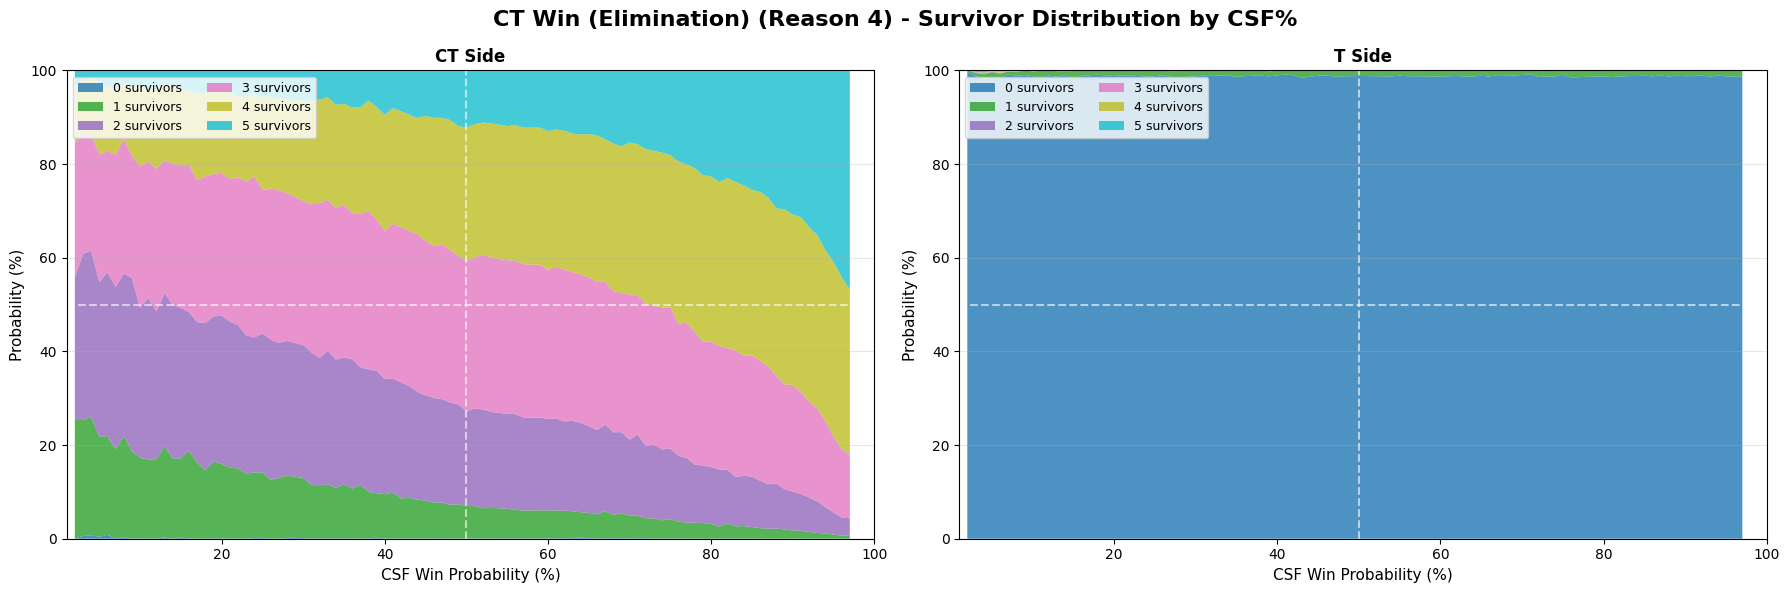

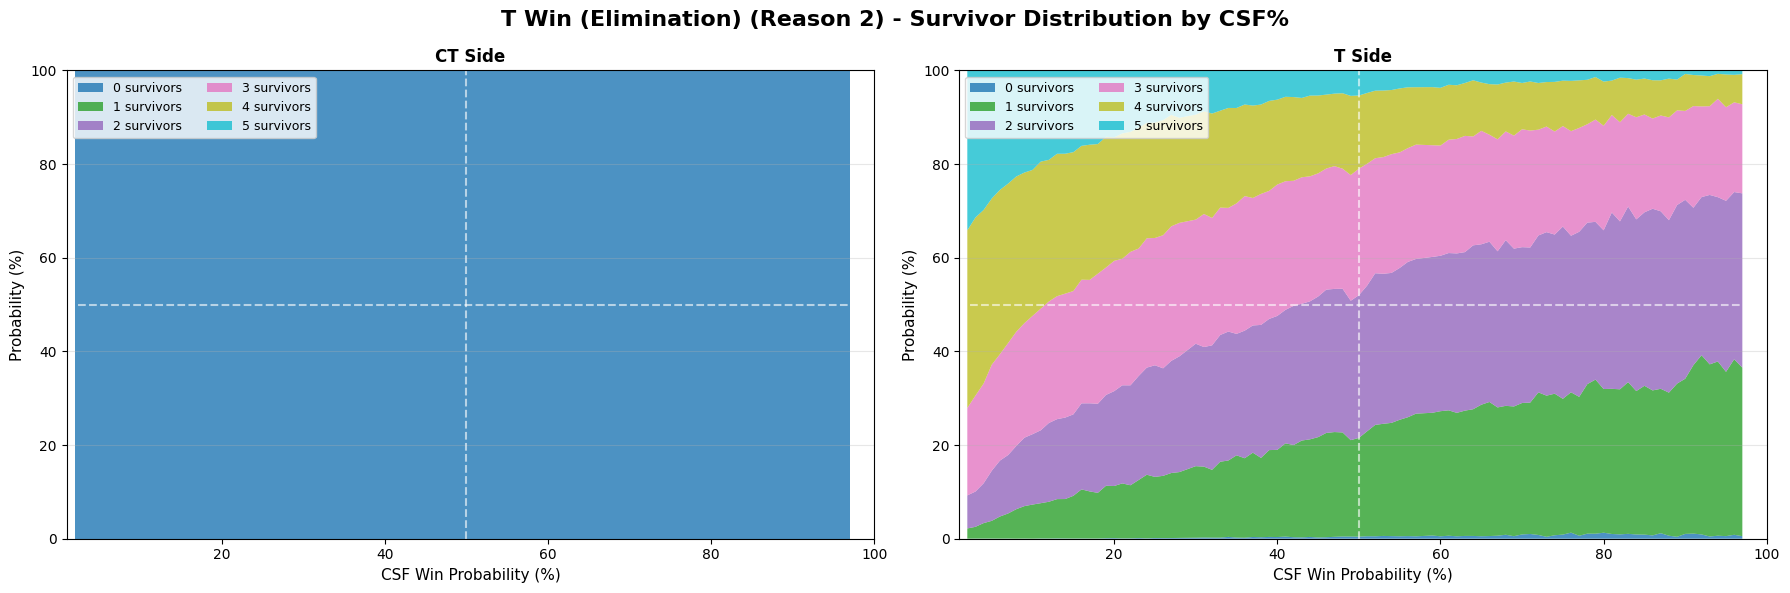

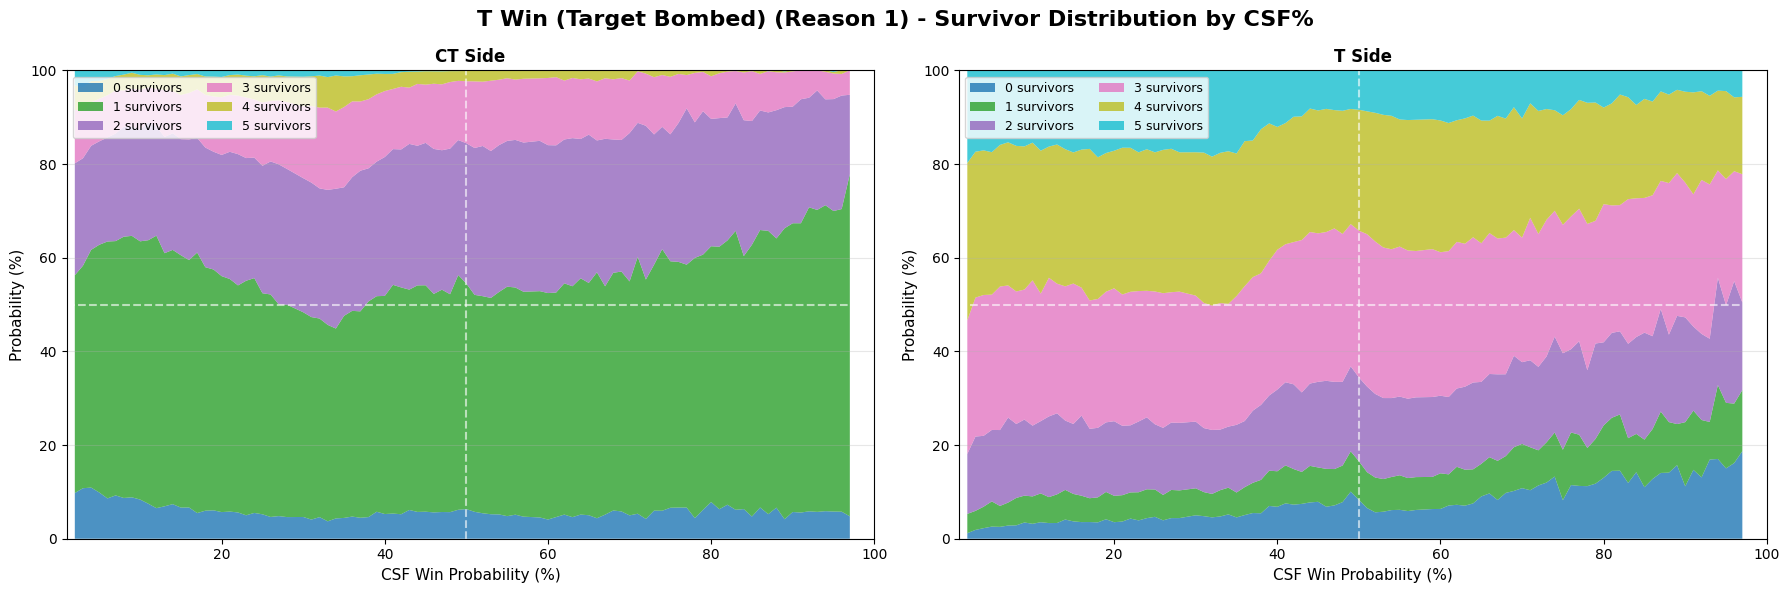

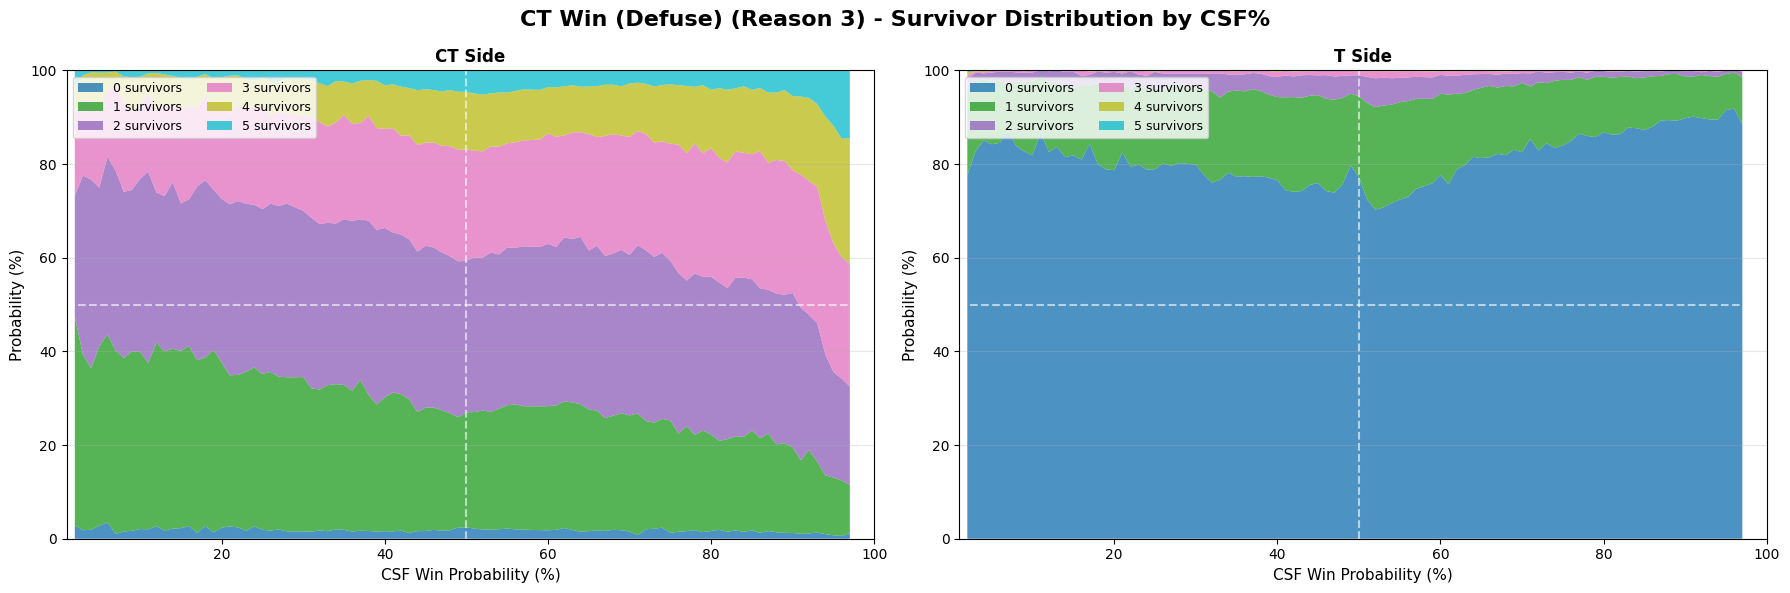

✅ Stacked distribution visualizations complete!



In [37]:
# Visualize survivor distributions with stacked area plots
print("📊 Creating stacked survivor distribution visualizations...")
print()

# Create visualizations for each round end reason
for reason in top_reasons:
    reason_name = reason_names.get(reason, f"Reason {reason}")
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'{reason_name} (Reason {reason}) - Survivor Distribution by CSF%', 
                 fontsize=16, fontweight='bold')
    
    # Plot for each side
    for side_idx, side in enumerate(['CT', 'T']):
        ax = axes[side_idx]
        
        if side in survivor_analysis and reason in survivor_analysis[side]:
            reason_data = survivor_analysis[side][reason]
            csf_data = reason_data.get('csf_distributions', {})
            
            if not csf_data:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=14)
                ax.set_xlabel('CSF Win Probability (%)', fontsize=11)
                ax.set_ylabel('Probability (%)', fontsize=11)
                ax.set_title(f'{side} Side', fontsize=12, fontweight='bold')
                continue
            
            # Prepare data: for each survivor count (0-5), track probability across CSF percentages
            csf_percentages = sorted(csf_data.keys())
            survivor_probs = {i: [] for i in range(6)}
            
            for csf_pct in csf_percentages:
                dist_data = csf_data[csf_pct]
                surv_prob_data = dist_data['survivor_probabilities']
                
                # Get individual probabilities directly
                for surv_count in range(6):
                    prob = surv_prob_data.get(surv_count, {}).get('probability', 0)
                    survivor_probs[surv_count].append(prob * 100)
            
            # Create stacked area plot
            colors = plt.cm.tab10(np.linspace(0, 1, 6))
            
            # Stack the areas (convert to numpy arrays for stacking)
            y_data = np.array([survivor_probs[i] for i in range(6)])
            
            # Plot stacked areas
            ax.stackplot(csf_percentages, y_data, 
                        labels=[f'{i} survivors' for i in range(6)],
                        colors=colors, alpha=0.8)
            
            # Formatting
            ax.set_xlabel('CSF Win Probability (%)', fontsize=11)
            ax.set_ylabel('Probability (%)', fontsize=11)
            ax.set_title(f'{side} Side', fontsize=12, fontweight='bold')
            ax.legend(loc='upper left', fontsize=9, ncol=2, bbox_to_anchor=(0, 1))
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_xlim(1, 100)
            ax.set_ylim(0, 100)
            
            # Add reference lines at 50%
            ax.axhline(y=50, color='white', linestyle='--', alpha=0.6, linewidth=1.5)
            ax.axvline(x=50, color='white', linestyle='--', alpha=0.6, linewidth=1.5)
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=14)
            ax.set_xlabel('CSF Win Probability (%)', fontsize=11)
            ax.set_ylabel('Probability (%)', fontsize=11)
            ax.set_title(f'{side} Side', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("✅ Stacked distribution visualizations complete!")
print()


📊 Creating survivor CDF visualizations...



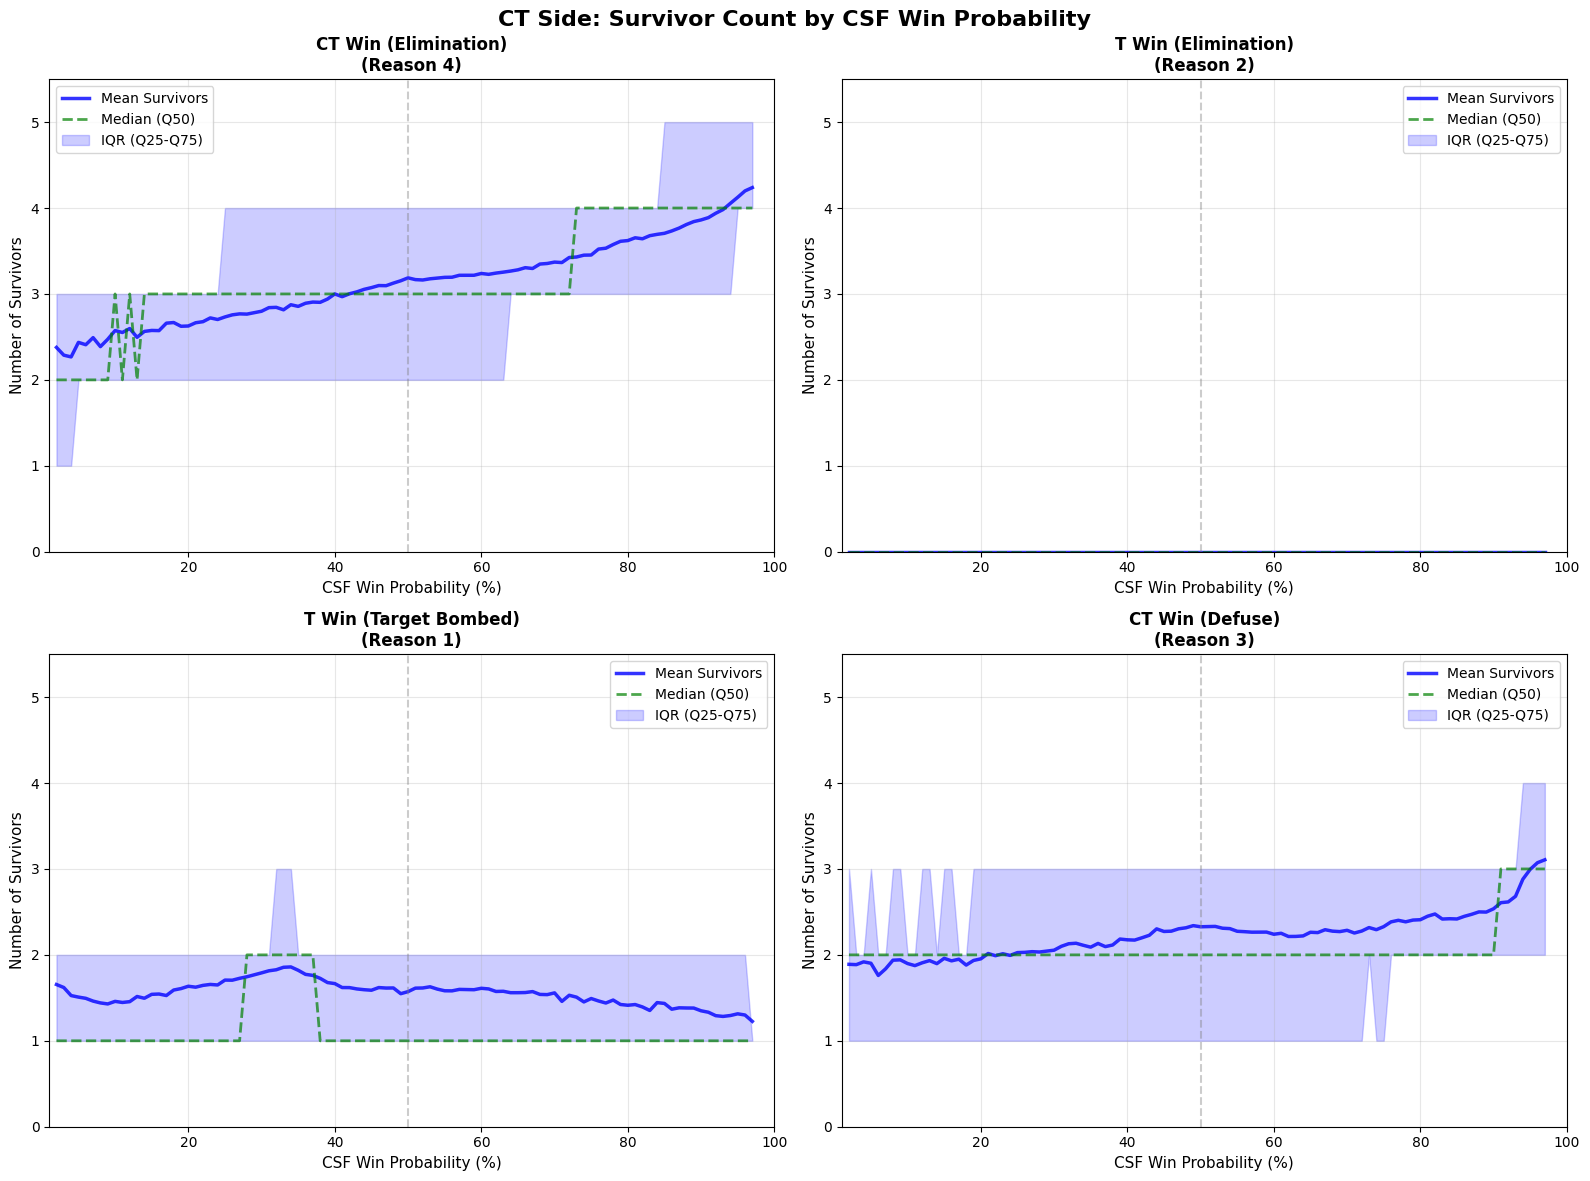

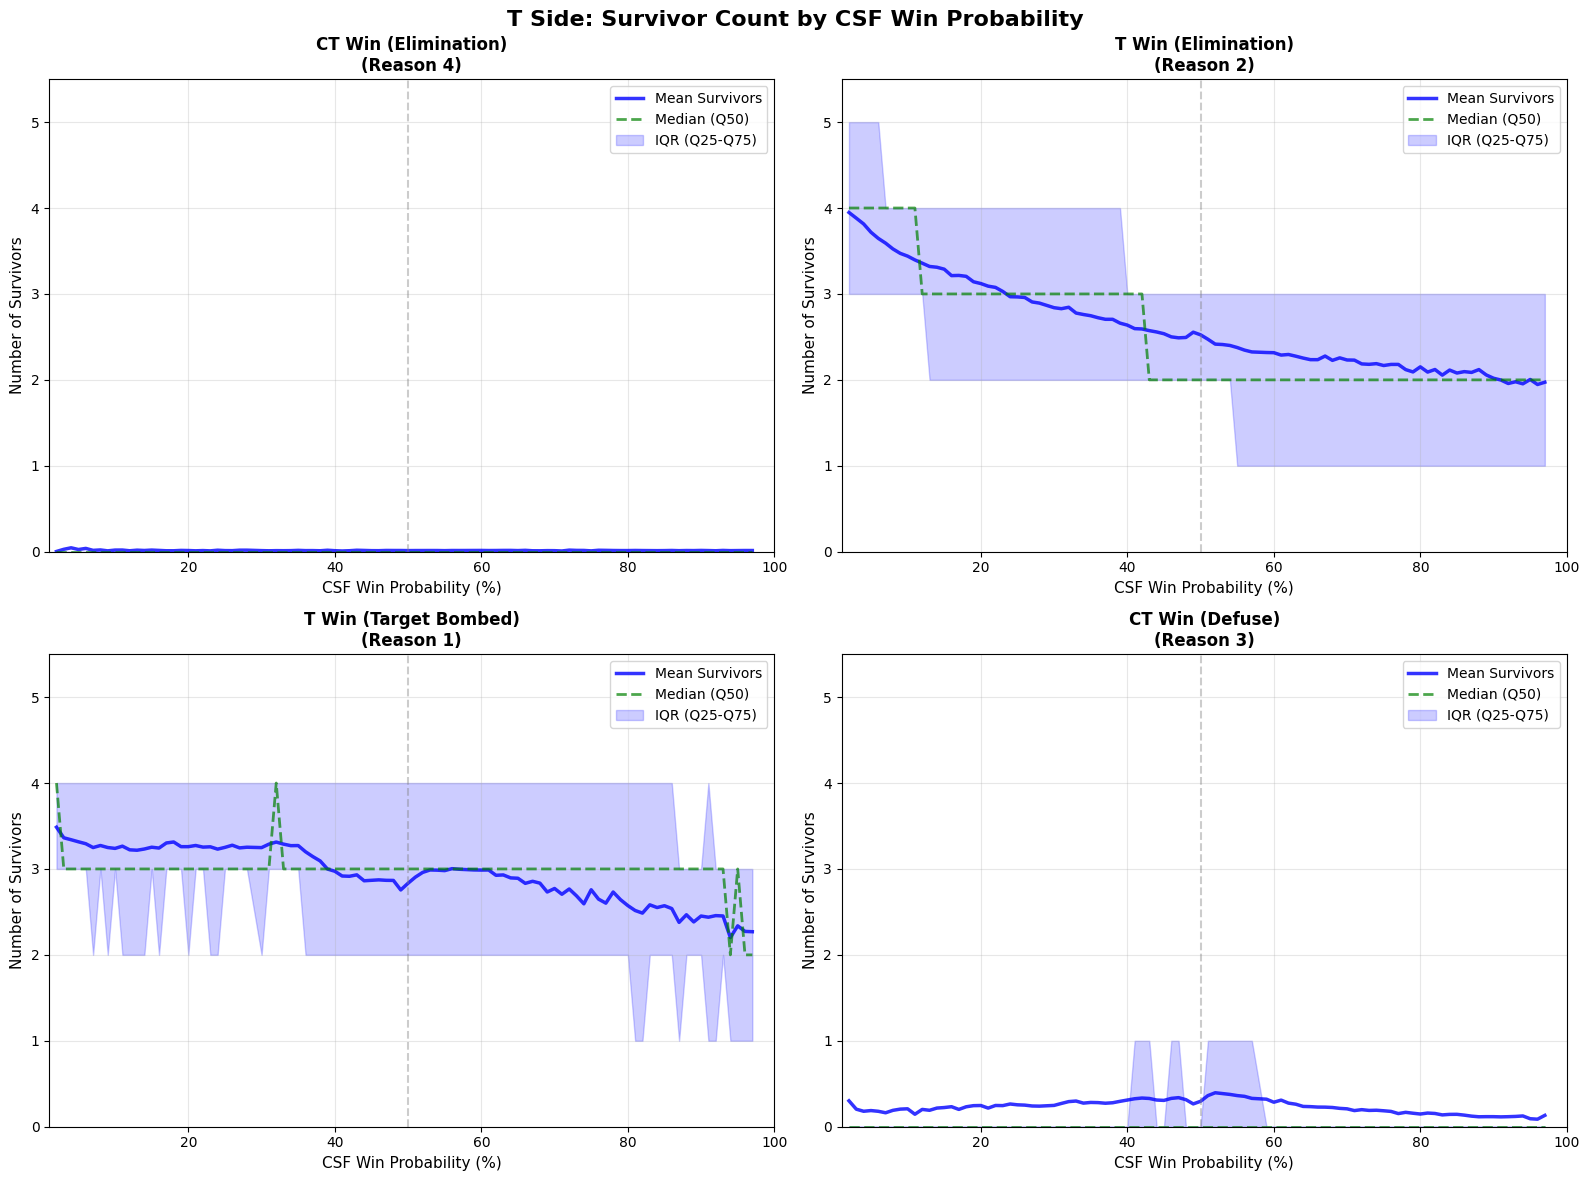

✅ Visualizations complete!

💡 KEY INSIGHTS:
   • CSF advantage affects survivor distribution
   • Different round end reasons show different patterns
   • Use these distributions in ABM to sample realistic survivor counts
   • Higher CSF advantage typically leads to more survivors


In [38]:
# Visualize survivor cumulative distributions by CSF percentage
print("📊 Creating survivor CDF visualizations...")
print()

for side in ['CT', 'T']:
    side_data = survivor_analysis[side]
    n_reasons = len(side_data)
    
    if n_reasons == 0:
        continue
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    fig.suptitle(f'{side} Side: Survivor Count by CSF Win Probability', fontsize=16, fontweight='bold')
    
    for idx, (reason, reason_info) in enumerate(side_data.items()):
        if idx >= 4:
            break
        
        ax = axes[idx]
        reason_name = reason_info['reason_name']
        csf_data = reason_info['csf_distributions']
        
        # Extract data for plotting
        csf_percentages = sorted(csf_data.keys())
        mean_survivors = [csf_data[csf]['mean_survivors'] for csf in csf_percentages]
        
        # Plot mean survivors
        ax.plot(csf_percentages, mean_survivors, 'b-', linewidth=2.5, label='Mean Survivors', alpha=0.8)
        
        # Plot quantiles (25th, 50th, 75th percentiles derived from CDF)
        q25_survivors = []
        q50_survivors = []
        q75_survivors = []
        
        for csf in csf_percentages:
            cdf = csf_data[csf]['cumulative_distribution']
            
            # Find survivor counts at quantiles
            q25_surv = next((s for s in range(6) if cdf[s] >= 0.25), 5)
            q50_surv = next((s for s in range(6) if cdf[s] >= 0.50), 5)
            q75_surv = next((s for s in range(6) if cdf[s] >= 0.75), 5)
            
            q25_survivors.append(q25_surv)
            q50_survivors.append(q50_surv)
            q75_survivors.append(q75_surv)
        
        ax.plot(csf_percentages, q50_survivors, 'g--', linewidth=2, label='Median (Q50)', alpha=0.7)
        ax.fill_between(csf_percentages, q25_survivors, q75_survivors, alpha=0.2, color='blue', label='IQR (Q25-Q75)')
        
        ax.set_xlabel('CSF Win Probability (%)', fontsize=11)
        ax.set_ylabel('Number of Survivors', fontsize=11)
        ax.set_title(f"{reason_name}\n(Reason {reason})", fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(1, 100)
        ax.set_ylim(0, 5.5)
        ax.set_yticks(range(0, 6))
        # Add vertical line at 50%
        ax.axvline(x=50, color='gray', linestyle='--', alpha=0.4, linewidth=1.5)
    
    # Hide unused subplots
    for idx in range(len(side_data), 4):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

print("✅ Visualizations complete!")
print()
print("💡 KEY INSIGHTS:")
print("   • CSF advantage affects survivor distribution")
print("   • Different round end reasons show different patterns")
print("   • Use these distributions in ABM to sample realistic survivor counts")
print("   • Higher CSF advantage typically leads to more survivors")

# Equipment Saved Per Survivor Analysis

Prepare data for quantile regression grouped by round end reason.

In [39]:
print("="*80)
print("📊 PREPARE EQUIPMENT SAVED DATA FOR QUANTILE REGRESSION")
print("="*80)
print()

# Prepare data for both CT and T sides with improved target variable
improved_regression_results = []

for side in ['CT', 'T']:
    print(f"🔹 Processing {side} side data...")
    
    # Select relevant columns
    if side == 'CT':
        df_side = detailed_df[['round_end_reason', 'ct_survivors', 'ct_equipment', 't_equipment', 'ct_saved_equipment']].copy()
        df_side.columns = ['round_end_reason', 'survivors', 'ct_equipment', 't_equipment', 'saved_equipment']
        df_side['is_ct'] = 1
    else:
        df_side = detailed_df[['round_end_reason', 't_survivors', 'ct_equipment', 't_equipment', 't_saved_equipment']].copy()
        df_side.columns = ['round_end_reason', 'survivors', 'ct_equipment', 't_equipment', 'saved_equipment']
        df_side['is_ct'] = 0
    
    # Remove rows with missing values, exclude rounds where no equipment was saved, or zero survivors
    df_side = df_side.dropna()
    df_side = df_side[(df_side['saved_equipment'] > 0) & (df_side['survivors'] > 0)].copy()
    
    # Calculate total equipment in the round
    df_side['total_equipment'] = df_side['ct_equipment'] + df_side['t_equipment']
    
    # Calculate equipment saved per survivor as % of total equipment
    df_side['saved_per_survivor_pct'] = (df_side['saved_equipment'] / df_side['survivors']) / df_side['total_equipment'] * 100
    
    # Remove false Data where saved equipment is more than total available (over 100%)
    df_side = df_side[df_side['saved_per_survivor_pct'] <= 100].copy()
    
    print(f"   Dataset: {len(df_side):,} rounds")
    print(f"   Mean: {df_side['saved_per_survivor_pct'].mean():.2f}% of total equipment saved per survivor")
    print()
    
    # Store results
    improved_regression_results.append({
        'side': side,
        'df_side': df_side
    })

print("✅ Data preparation complete")
print()

📊 PREPARE EQUIPMENT SAVED DATA FOR QUANTILE REGRESSION

🔹 Processing CT side data...
   Dataset: 1,538,238 rounds
   Mean: 11.83% of total equipment saved per survivor

🔹 Processing T side data...
   Dataset: 1,166,790 rounds
   Mean: 11.98% of total equipment saved per survivor

✅ Data preparation complete



In [40]:
print("="*80)
print("📊 EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTION (ECDF) ANALYSIS")
print("📊 Equipment Saved Per Survivor (% of Total Equipment)")
print("="*80)
print()

# Store ECDF results for JSON export
equipment_distributions = {}

for side in ['CT', 'T']:
    print(f"\n{'='*80}")
    print(f"🔹 {side} SIDE - EQUIPMENT SAVED DISTRIBUTIONS")
    print(f"{'='*80}\n")
    
    equipment_distributions[side] = {}
    
    # Get data from improved regression
    df_side = improved_regression_results[0 if side == 'CT' else 1]['df_side'].copy()
    
    # Process each of the top 4 round end reasons
    for reason in top_reasons:
        reason_name = reason_names.get(reason, f"Reason {reason}")
        print(f"\n   {'─'*70}")
        print(f"   🎯 {reason_name} (Reason {reason})")
        print(f"   {'─'*70}")
        
        # Filter data for this round end reason
        df_reason = df_side[df_side['round_end_reason'] == reason].copy()
        
        if len(df_reason) < 50:  # Skip if insufficient data
            print(f"   ⚠️  Insufficient data ({len(df_reason)} rounds) - skipping")
            continue
        
        equipment_distributions[side][reason] = {
            'reason_name': reason_name,
            'survivor_distributions': {}
        }
        
        # Analyze for each survivor count (1-5)
        for surv in range(1, 6):
            df_surv = df_reason[df_reason['survivors'] == surv].copy()
            
            if len(df_surv) < 10:
                continue
            
            # Get equipment saved percentages
            eq_saved_pct = df_surv['saved_per_survivor_pct'].values
            
            # Calculate ECDF (Empirical Cumulative Distribution Function)
            sorted_data = np.sort(eq_saved_pct)
            ecdf_x = sorted_data
            ecdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            
            # Calculate statistics
            stats_dict = {
                'n_samples': len(eq_saved_pct),
                'mean': float(eq_saved_pct.mean()),
                'median': float(np.median(eq_saved_pct)),
                'std': float(eq_saved_pct.std()),
                'min': float(eq_saved_pct.min()),
                'max': float(eq_saved_pct.max()),
                'q25': float(np.percentile(eq_saved_pct, 25)),
                'q75': float(np.percentile(eq_saved_pct, 75)),
                # Store ECDF for export (sample to ~200 points for accuracy)
                'ecdf': {
                    'x': [float(x) for x in ecdf_x[::max(1, len(ecdf_x)//200)].tolist()],
                    'y': [float(y) for y in ecdf_y[::max(1, len(ecdf_y)//200)].tolist()]
                }
            }
            
            equipment_distributions[side][reason]['survivor_distributions'][surv] = stats_dict
            
            # Print summary
            print(f"\n   {surv} Survivor{'s' if surv > 1 else ''} (n={len(eq_saved_pct):,}):")
            print(f"      Mean: {stats_dict['mean']:.2f}%  |  Median: {stats_dict['median']:.2f}%  |  Std: {stats_dict['std']:.2f}%")
            print(f"      Range: [{stats_dict['min']:.2f}%, {stats_dict['max']:.2f}%]  |  IQR: [{stats_dict['q25']:.2f}%, {stats_dict['q75']:.2f}%]")
            print(f"      ECDF Points: {len(stats_dict['ecdf']['x'])}")

print("\n" + "="*80)
print("✅ ECDF ANALYSIS COMPLETE")
print("="*80)
print()
print("💡 Distributions stored for JSON export")
print("   • ECDF: Empirical Cumulative Distribution Function")
print("   • Use inverse transform sampling in ABM for stochastic equipment values")


📊 EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTION (ECDF) ANALYSIS
📊 Equipment Saved Per Survivor (% of Total Equipment)


🔹 CT SIDE - EQUIPMENT SAVED DISTRIBUTIONS


   ──────────────────────────────────────────────────────────────────────
   🎯 CT Win (Elimination) (Reason 4)
   ──────────────────────────────────────────────────────────────────────

   1 Survivor (n=44,445):
      Mean: 12.74%  |  Median: 12.18%  |  Std: 3.59%
      Range: [0.75%, 55.62%]  |  IQR: [10.31%, 14.43%]
      ECDF Points: 201

   2 Survivors (n=140,545):
      Mean: 11.85%  |  Median: 11.11%  |  Std: 3.32%
      Range: [0.91%, 46.02%]  |  IQR: [9.81%, 13.36%]
      ECDF Points: 201

   3 Survivors (n=238,778):
      Mean: 11.91%  |  Median: 10.85%  |  Std: 3.67%
      Range: [0.63%, 78.06%]  |  IQR: [9.66%, 14.16%]
      ECDF Points: 201

   4 Survivors (n=253,718):
      Mean: 12.64%  |  Median: 11.40%  |  Std: 4.13%
      Range: [0.42%, 47.00%]  |  IQR: [9.71%, 16.19%]
      ECDF Points: 201

   5 Survivors (n=

📊 Creating ECDF visualizations...



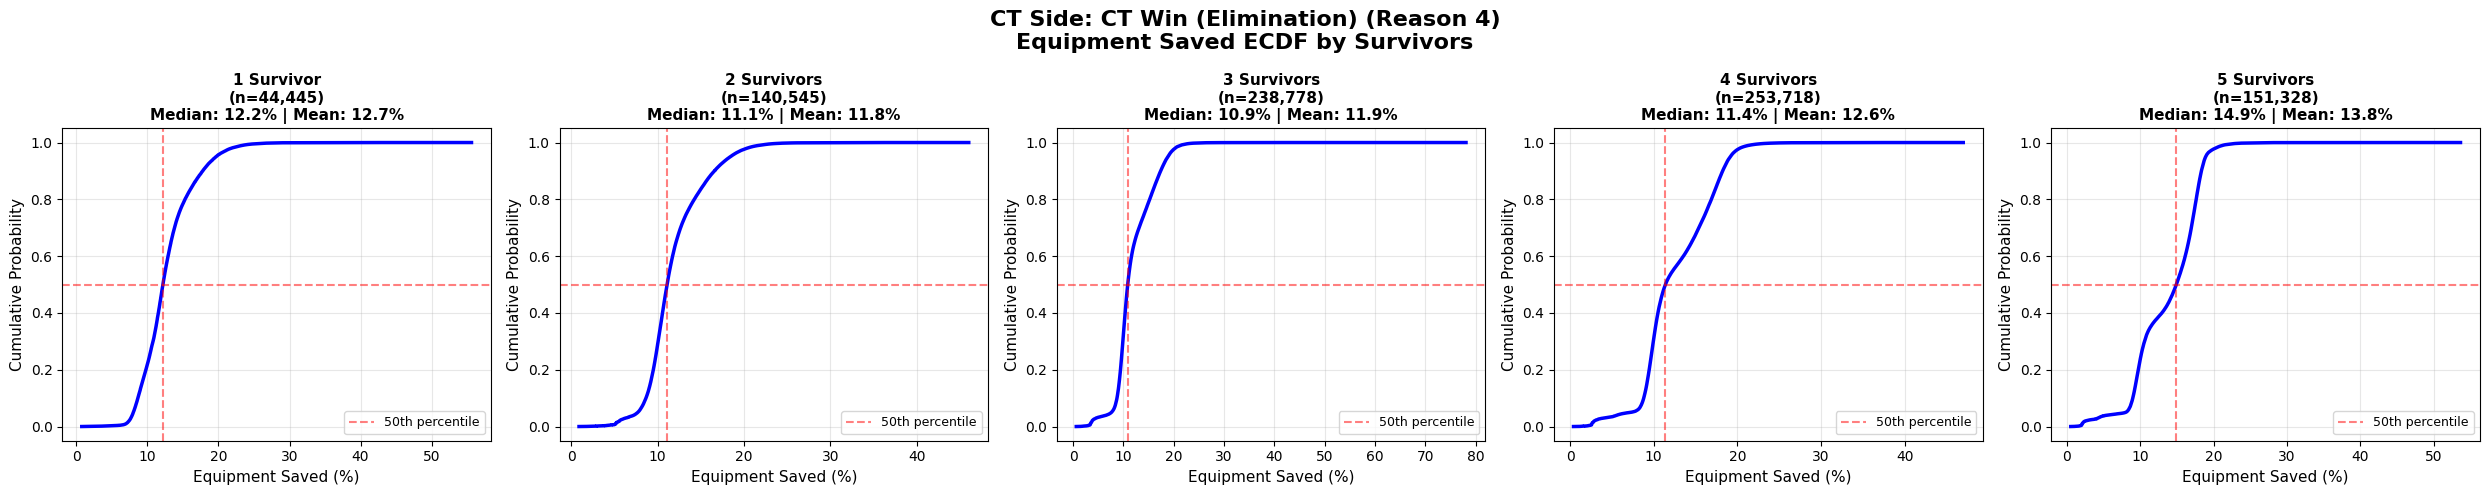

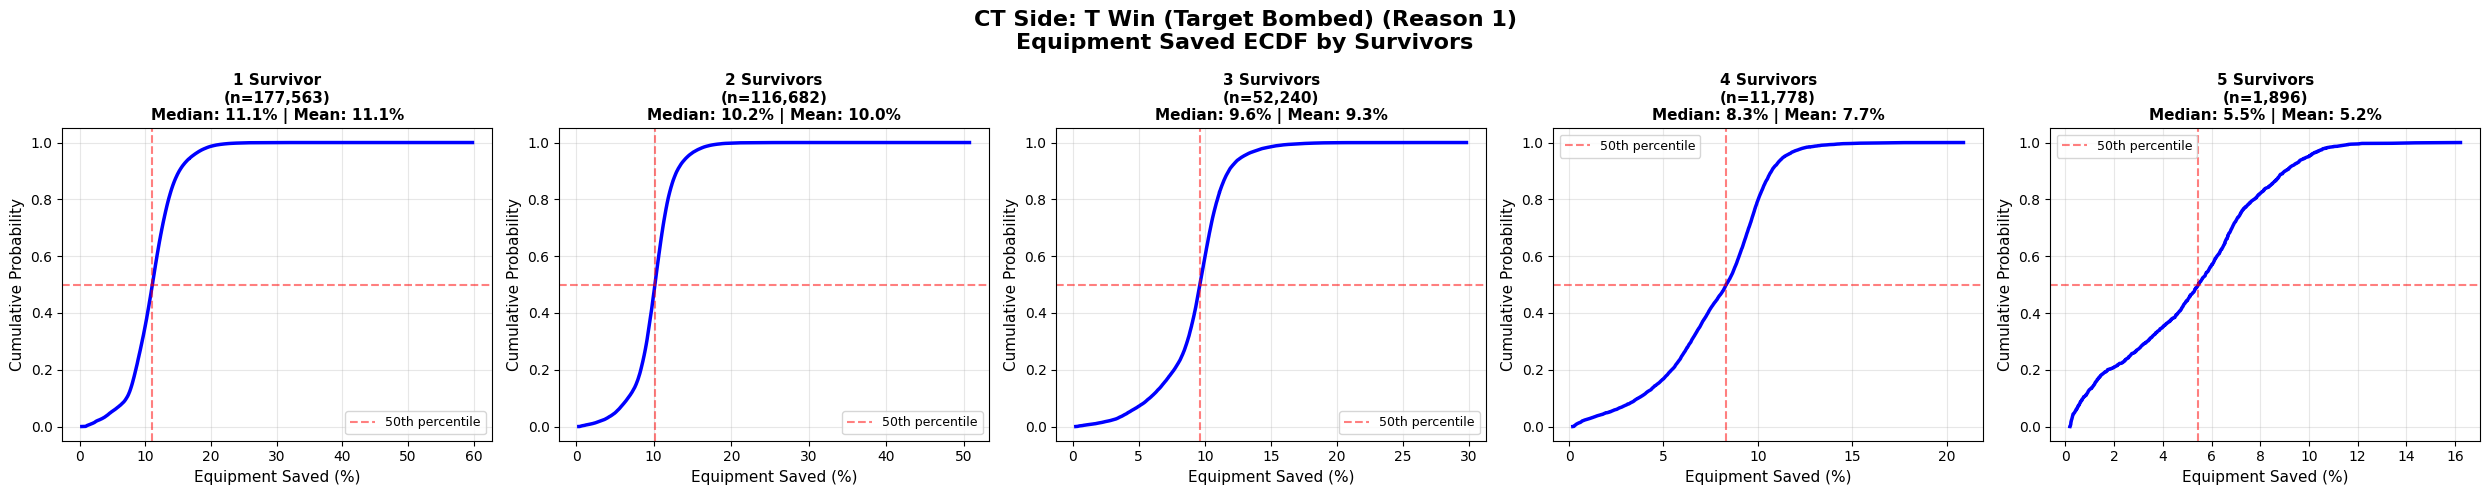

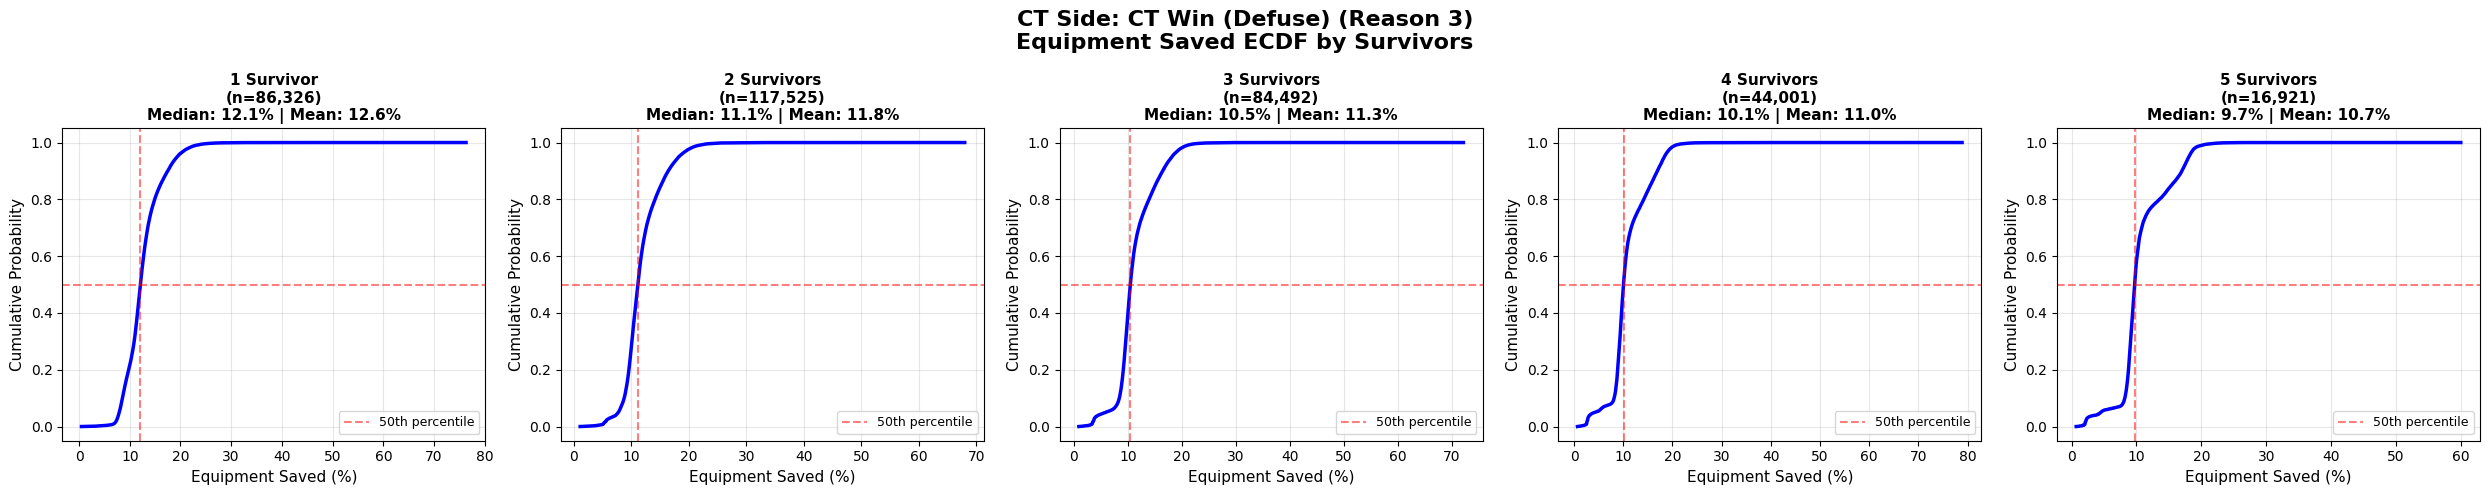

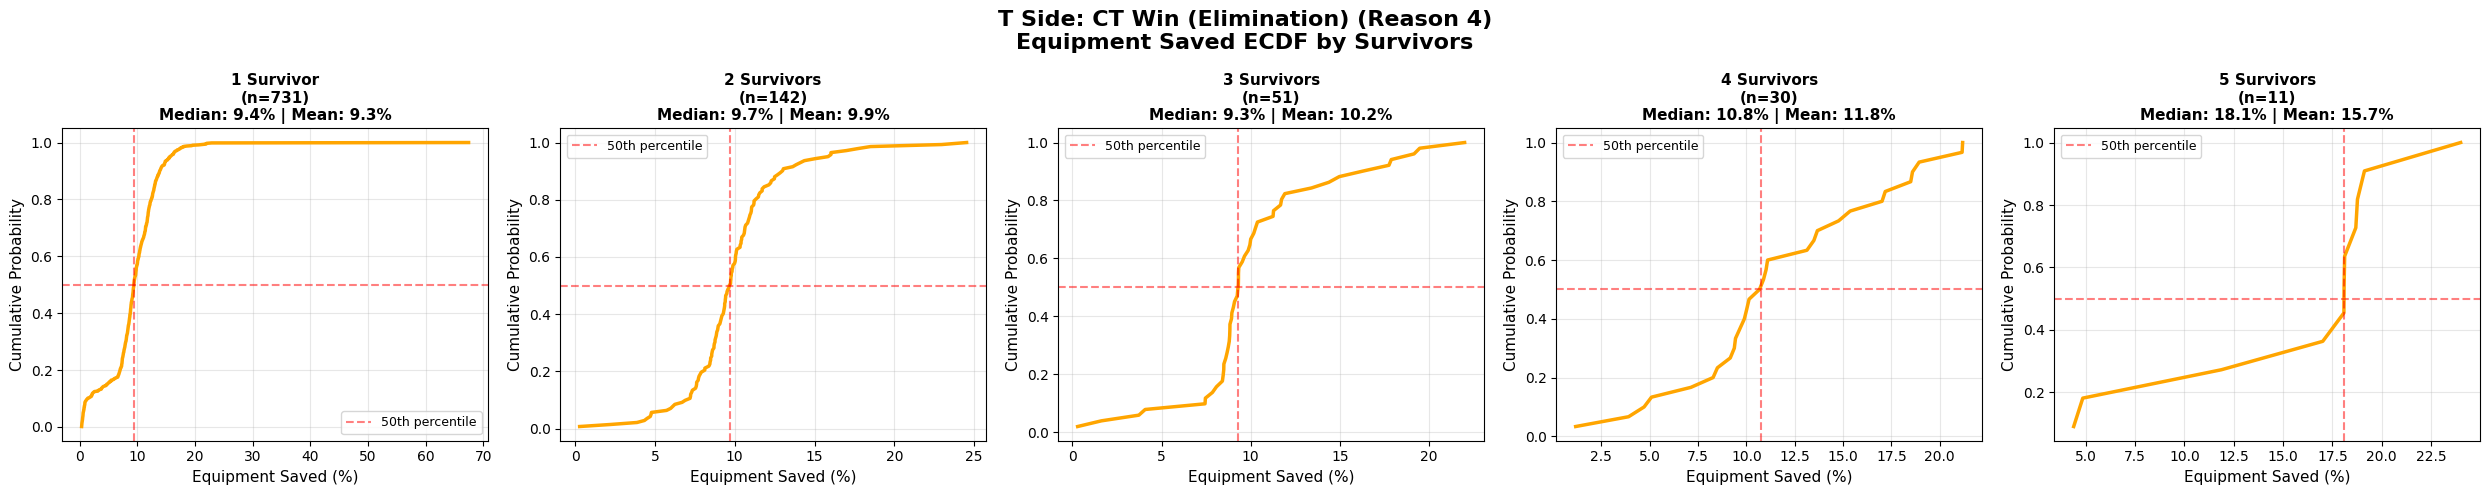

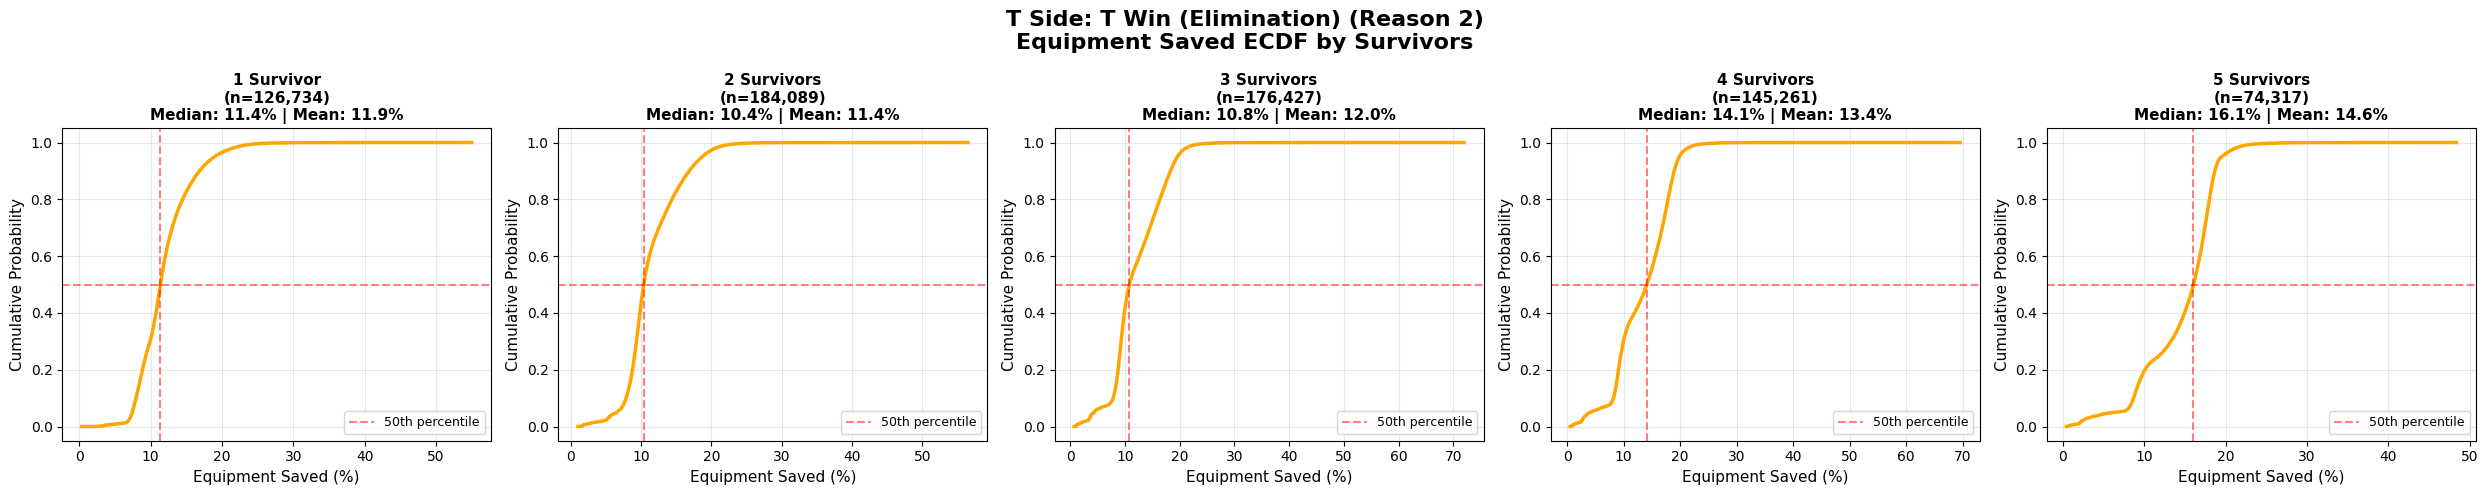

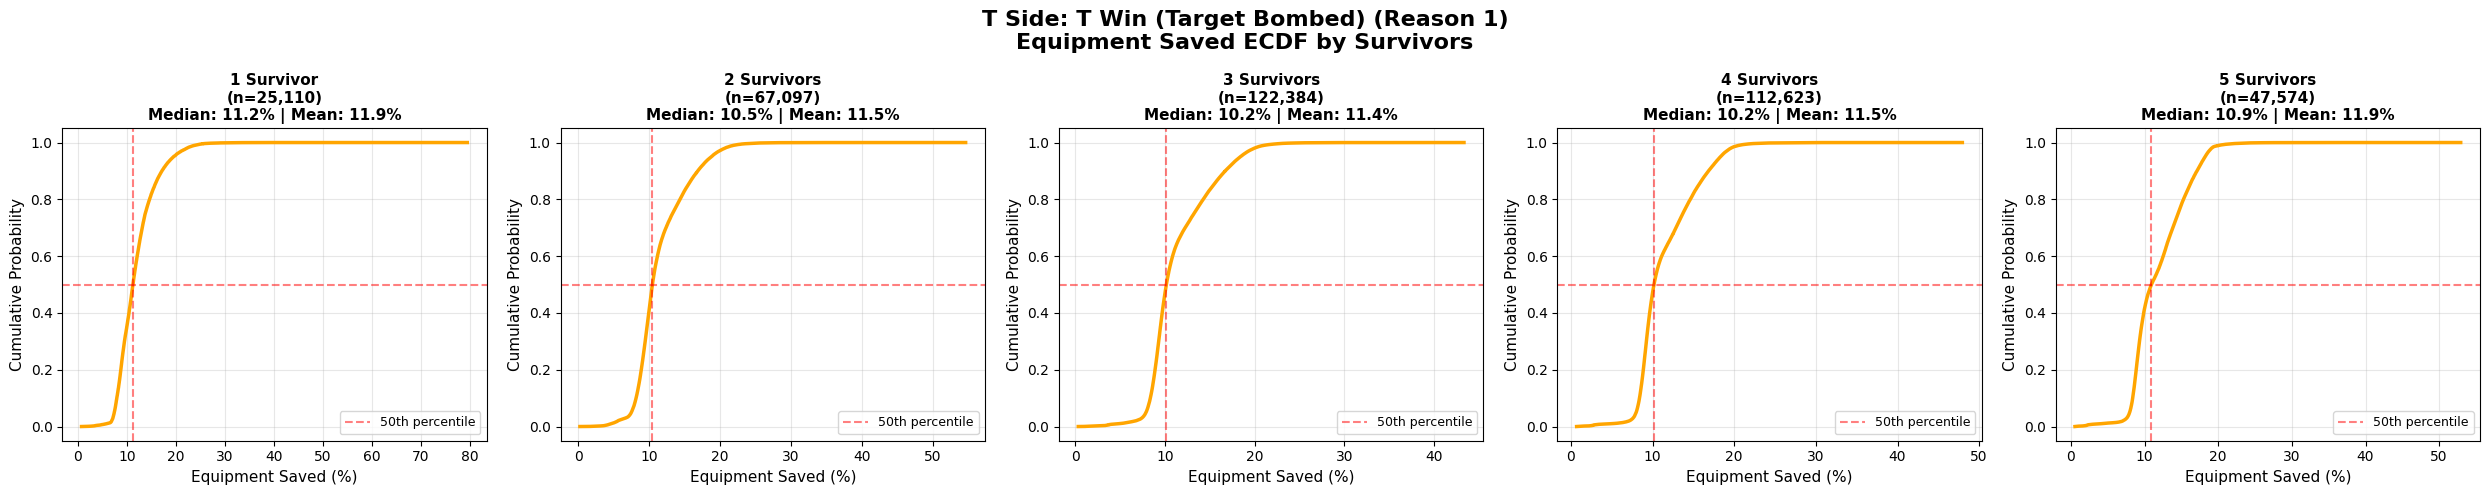

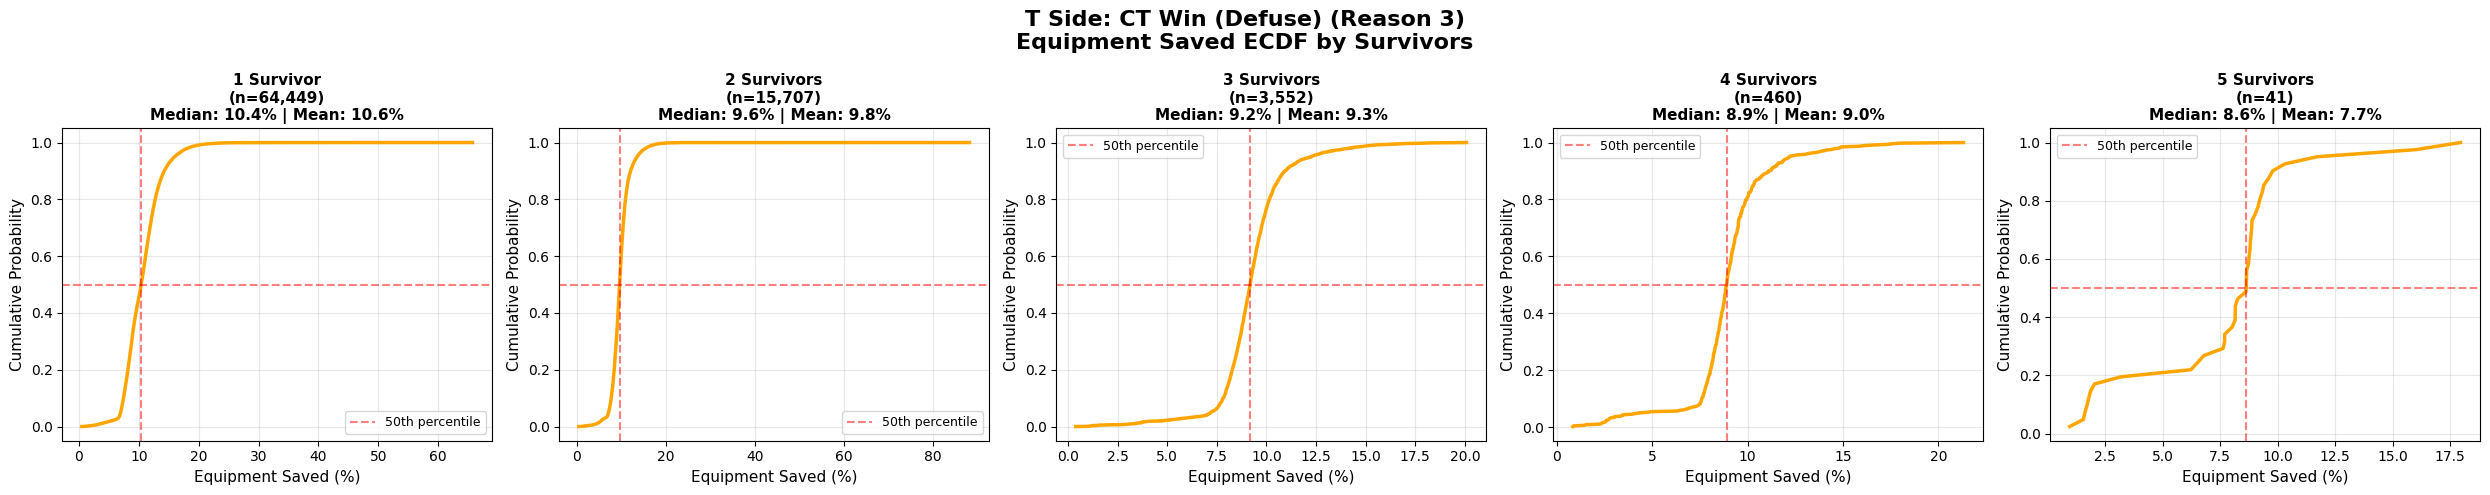

✅ ECDF visualizations complete!

💡 KEY INSIGHTS:
   • ECDF shows cumulative probability distribution from actual data
   • Red dashed lines mark the median (50th percentile)
   • Use inverse transform sampling in ABM: sample u~U(0,1), find x where ECDF(x)=u


In [41]:
# Visualize ECDF for equipment saved distributions
print("📊 Creating ECDF visualizations...")
print()

for side in ['CT', 'T']:
    if side not in equipment_distributions:
        continue
    
    side_data = equipment_distributions[side]
    
    # Create visualization for each round end reason
    for reason, reason_data in side_data.items():
        if isinstance(reason, int):  # Skip if not a reason number
            reason_name = reason_data['reason_name']
            surv_dists = reason_data['survivor_distributions']
            
            if not surv_dists:
                continue
            
            # Count how many survivors have data
            n_survivors = len(surv_dists)
            
            # Create subplots: 1 row for ECDF, n_survivors columns
            fig, axes = plt.subplots(1, n_survivors, figsize=(5*n_survivors, 5))
            if n_survivors == 1:
                axes = [axes]
            
            fig.suptitle(f'{side} Side: {reason_name} (Reason {reason})\nEquipment Saved ECDF by Survivors', 
                         fontsize=16, fontweight='bold')
            
            for idx, (surv, dist_data) in enumerate(sorted(surv_dists.items())):
                # Get the actual data for plotting
                df_side = improved_regression_results[0 if side == 'CT' else 1]['df_side']
                df_plot = df_side[(df_side['round_end_reason'] == reason) & 
                                  (df_side['survivors'] == surv)]
                eq_saved_pct = df_plot['saved_per_survivor_pct'].values
                
                if len(eq_saved_pct) < 10:
                    continue
                
                # ECDF Plot
                ax = axes[idx]
                sorted_data = np.sort(eq_saved_pct)
                ecdf_y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
                ax.plot(sorted_data, ecdf_y, linewidth=2.5, color='blue' if side == 'CT' else 'orange')
                ax.set_xlabel('Equipment Saved (%)', fontsize=11)
                ax.set_ylabel('Cumulative Probability', fontsize=11)
                ax.set_title(f'{surv} Survivor{"s" if surv > 1 else ""}\n(n={dist_data["n_samples"]:,})\n' +
                           f'Median: {dist_data["median"]:.1f}% | Mean: {dist_data["mean"]:.1f}%', 
                           fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3)
                ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='50th percentile')
                ax.axvline(x=dist_data['median'], color='red', linestyle='--', alpha=0.5, linewidth=1.5)
                ax.legend(loc='best', fontsize=9)
            
            plt.tight_layout()
            plt.show()

print("✅ ECDF visualizations complete!")
print()
print("💡 KEY INSIGHTS:")
print("   • ECDF shows cumulative probability distribution from actual data")
print("   • Red dashed lines mark the median (50th percentile)")
print("   • Use inverse transform sampling in ABM: sample u~U(0,1), find x where ECDF(x)=u")

In [42]:
import json

# Export all analysis results to JSON for Go ABM
print("="*80)
print("📤 EXPORTING ALL ABM DATA TO JSON")
print("="*80)
print()

# Reason names for new recoded values
REASON_NAMES = {
    1: "T Win (Target Bombed)",
    2: "T Win (Elimination)",
    3: "CT Win (Defuse)",
    4: "CT Win (Elimination)",
}

print("🔹 Round end reason codes (already recoded in dataset):")
for reason_code, reason_name in REASON_NAMES.items():
    count = (detailed_df['round_end_reason'] == reason_code).sum()
    pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
    print(f"   {reason_code}: {reason_name} - {count:,} rounds ({pct:.2f}%)")
print()

# Convert numpy types to native Python types for JSON
def convert_to_native_types(obj):
    if isinstance(obj, dict):
        return {k: convert_to_native_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    else:
        return obj

# Convert CSF percentages from string keys to integers (1-100)
def convert_csf_keys_to_int(analysis_dict):
    """Convert CSF percentage keys from any format to integers 1-100"""
    converted = {}
    for key, value in analysis_dict.items():
        if isinstance(key, str) and key.isdigit():
            int_key = int(key)
            if 1 <= int_key <= 100:
                converted[int_key] = convert_to_native_types(value)
        elif isinstance(key, int) and 1 <= key <= 100:
            converted[key] = convert_to_native_types(value)
        else:
            # Keep non-CSF keys as-is (e.g., 'CT', 'T', reason numbers)
            converted[key] = convert_to_native_types(value) if isinstance(value, dict) else value
    return converted

def interpolate_missing_csf_values(data_dict):
    """
    Fill in missing CSF percentage values by interpolating between neighbors.
    Ensures continuous CSF coverage from min to max.
    Only interpolates numeric values (probabilities, stats), not categorical data.
    """
    if not data_dict:
        return data_dict
    
    # Get available CSF percentages
    csf_values = sorted([k for k in data_dict.keys() if isinstance(k, int)])
    if len(csf_values) < 2:
        return data_dict
    
    min_csf = min(csf_values)
    max_csf = max(csf_values)
    
    # Create interpolated data for missing values
    for csf in range(min_csf, max_csf + 1):
        if csf not in data_dict:
            # Find nearest lower and upper neighbors
            lower = max([v for v in csf_values if v < csf], default=None)
            upper = min([v for v in csf_values if v > csf], default=None)
            
            if lower is not None and upper is not None:
                # Average the two neighbors
                lower_data = data_dict[lower]
                upper_data = data_dict[upper]
                
                # Deep copy structure and average numeric values
                interpolated = {}
                for key in lower_data.keys():
                    if isinstance(lower_data[key], (int, float)):
                        interpolated[key] = (lower_data[key] + upper_data[key]) / 2
                    elif isinstance(lower_data[key], dict):
                        # Recursively interpolate nested dicts
                        interpolated[key] = {}
                        for subkey in lower_data[key].keys():
                            lower_val = lower_data[key][subkey]
                            upper_val = upper_data[key].get(subkey, lower_val)
                            
                            if isinstance(lower_val, (int, float)):
                                interpolated[key][subkey] = (lower_val + upper_val) / 2
                            elif isinstance(lower_val, dict):
                                interpolated[key][subkey] = {}
                                for subsubkey in lower_val.keys():
                                    lower_subval = lower_val[subsubkey]
                                    upper_subval = upper_val.get(subsubkey, lower_subval) if isinstance(upper_val, dict) else lower_subval
                                    
                                    # Don't interpolate if key contains 'reason' or 'name' (categorical data)
                                    if 'reason' in subsubkey.lower() or 'name' in subsubkey.lower():
                                        interpolated[key][subkey][subsubkey] = lower_subval
                                    elif isinstance(lower_subval, (int, float)):
                                        interpolated[key][subkey][subsubkey] = (lower_subval + upper_subval) / 2
                                    else:
                                        # Copy non-numeric values (like reason codes, names) from lower
                                        interpolated[key][subkey][subsubkey] = lower_subval
                            else:
                                # Copy non-numeric values (like reason codes, names) from lower
                                interpolated[key][subkey] = lower_val
                    else:
                        # Copy non-numeric values from lower
                        interpolated[key] = lower_data[key]
                
                # If this has reason_distribution, rebuild cumulative_distribution from it
                if 'reason_distribution' in interpolated and 'cumulative_distribution' in lower_data:
                    cumulative_reason_dist = {}
                    cumulative_prob = 0.0
                    # Sort by reason code for consistent ordering
                    sorted_reasons = sorted(interpolated['reason_distribution'].keys())
                    for reason_code in sorted_reasons:
                        reason_info = interpolated['reason_distribution'][reason_code]
                        probability = reason_info['probability']
                        
                        # Skip if probability is 0
                        if probability == 0:
                            continue
                            
                        cumulative_prob += probability
                        cumulative_key = int(np.ceil(cumulative_prob * 100))
                        # Only set if this key doesn't exist yet (first entry wins)
                        if cumulative_key not in cumulative_reason_dist:
                            cumulative_reason_dist[cumulative_key] = {
                                'reason': int(reason_code),
                                'reason_name': reason_info['reason_name'],
                                'cumulative_probability': cumulative_prob
                            }
                    interpolated['cumulative_distribution'] = cumulative_reason_dist
                
                # Mark interpolated data with n_rounds = 0 (indicating estimated values)
                if 'n_rounds' in interpolated:
                    interpolated['n_rounds'] = 0
                if 'n_samples' in interpolated:
                    interpolated['n_samples'] = 0
                
                # Also mark count fields in nested structures (like reason_distribution)
                for key in interpolated.keys():
                    if isinstance(interpolated[key], dict):
                        # Ensure cumulative_lookup values are integers (survivor counts)
                        if key == 'cumulative_lookup':
                            for lookup_key in interpolated[key].keys():
                                interpolated[key][lookup_key] = int(round(interpolated[key][lookup_key]))
                        
                        for subkey in interpolated[key].keys():
                            if isinstance(interpolated[key][subkey], dict):
                                if 'count' in interpolated[key][subkey]:
                                    interpolated[key][subkey]['count'] = 0
                
                data_dict[csf] = interpolated
    
    # Return sorted by CSF percentage
    return dict(sorted(data_dict.items()))

print("🔹 Converting round end reason analysis...")
round_end_reason_export = {}
for side, side_data in round_end_reason_analysis.items():
    round_end_reason_export[side] = {}
    for csf_pct, csf_data in side_data.items():
        csf_converted = convert_csf_keys_to_int({csf_pct: csf_data})[csf_pct]
        
        # Build cumulative distribution for round end reasons (for fast sampling)
        cumulative_reason_dist = {}
        if 'reason_distribution' in csf_converted:
            cumulative_prob = 0.0
            # Sort by reason code for consistent ordering
            sorted_reasons = sorted(csf_converted['reason_distribution'].keys())
            for reason_code in sorted_reasons:
                reason_info = csf_converted['reason_distribution'][reason_code]
                probability = reason_info['probability']
                
                # Skip if probability is 0
                if probability == 0:
                    continue
                    
                cumulative_prob += probability
                # Use cumulative probability * 100 as integer key (0-100), always round up
                cumulative_key = int(np.ceil(cumulative_prob * 100))
                # Only set if this key doesn't exist yet (first entry wins)
                if cumulative_key not in cumulative_reason_dist:
                    cumulative_reason_dist[cumulative_key] = {
                        'reason': int(reason_code),  # Ensure integer without decimal
                        'reason_name': reason_info['reason_name'],
                        'cumulative_probability': cumulative_prob
                    }
        
        # Reorganize: cumulative distribution first for O(1) sampling, then individual probabilities, then metadata
        reorganized = {
            'cumulative_distribution': cumulative_reason_dist,
            'reason_distribution': csf_converted.get('reason_distribution', {}),
            'n_rounds': csf_converted.get('n_rounds', 0)
        }
        
        round_end_reason_export[side][csf_pct] = reorganized
    
    # Interpolate missing CSF values
    print(f"   Interpolating missing CSF values for {side} side...")
    round_end_reason_export[side] = interpolate_missing_csf_values(round_end_reason_export[side])

print(f"   ✅ Exported round end reason distributions for CT and T sides")
print()

print("🔹 Converting survivor analysis...")
survivor_distributions_export = {}
for side, side_data in survivor_analysis.items():
    survivor_distributions_export[side] = {}
    for reason, reason_data in side_data.items():
        survivor_distributions_export[side][reason] = {
            'reason_name': reason_data['reason_name'],
            'csf_distributions': {}
        }
        
        for csf_pct, csf_data in reason_data['csf_distributions'].items():
            # Create cumulative lookup table for fast sampling
            cumulative_lookup = {}
            survivor_probs = csf_data['survivor_probabilities']
            
            cumulative_prob = 0.0
            for n_survivors in range(0, 6):
                prob = survivor_probs.get(n_survivors, {}).get('probability', 0)
                cumulative_prob += prob
                
                # Map cumulative probability % (0-100) to survivor count
                cum_key = int(np.ceil(cumulative_prob * 100))
                if cum_key not in cumulative_lookup:
                    cumulative_lookup[cum_key] = n_survivors
            
            # Reorganize: cumulative lookup first for O(1) sampling
            reorganized_survs = {
                'cumulative_lookup': cumulative_lookup,
                'survivor_probabilities': convert_to_native_types(survivor_probs),
                'cumulative_distribution': convert_to_native_types(csf_data['cumulative_distribution']),
                'n_rounds': csf_data['n_rounds']
            }
            
            survivor_distributions_export[side][reason]['csf_distributions'][csf_pct] = reorganized_survs
        
        # Interpolate missing CSF values
        print(f"   Interpolating missing CSF values for {side} side, reason {reason}...")
        survivor_distributions_export[side][reason]['csf_distributions'] = interpolate_missing_csf_values(
            survivor_distributions_export[side][reason]['csf_distributions']
        )

print(f"   ✅ Exported survivor distributions for CT and T sides, all reasons")
print()

print("🔹 Converting bomb planted analysis...")
bomb_planted_export = {}
for side, side_data in bomb_planted_analysis.items():
    bomb_planted_export[side] = {}
    for csf_pct, csf_data in side_data.items():
        bomb_planted_export[side][csf_pct] = convert_to_native_types(csf_data)
    
    # Interpolate missing CSF values
    print(f"   Interpolating missing CSF values for {side} side...")
    bomb_planted_export[side] = interpolate_missing_csf_values(bomb_planted_export[side])

print(f"   ✅ Exported bomb planted distributions for T side")
print()

print("🔹 Converting equipment saved distributions...")
equipment_distributions_export = {}
for side, side_data in equipment_distributions.items():
    equipment_distributions_export[side] = {}
    for reason, reason_data in side_data.items():
        equipment_distributions_export[side][reason] = {
            'reason_name': reason_data['reason_name'],
            'survivor_distributions': convert_to_native_types(reason_data['survivor_distributions'])
        }

print(f"   ✅ Exported equipment saved distributions for CT and T sides, all reasons")
print()

# Create final export data
export_data = {
    'metadata': {
        'description': 'ABM distributions for CS:GO round simulations',
        'generated_at': pd.Timestamp.now().isoformat(),
        'n_rounds': len(detailed_df),
        'csf_exponent': float(csf_r_value),
        'reason_codes': REASON_NAMES
    },
    'round_end_reasons': round_end_reason_export,
    'survivors': survivor_distributions_export,
    'bomb_planted': bomb_planted_export,
    'equipment_saved': equipment_distributions_export
}

# Save to JSON
output_file = 'abm_distributions.json'
with open(output_file, 'w') as f:
    json.dump(export_data, f, indent=2)

print("="*80)
print(f"✅ EXPORT COMPLETE: {output_file}")
print("="*80)
print()
print(f"📊 Exported Data Summary:")
print(f"   • Round End Reasons: {sum(len(round_end_reason_export[s]) for s in round_end_reason_export)} CSF entries")
print(f"   • Survivors: {sum(sum(len(survivor_distributions_export[s][r]['csf_distributions']) for r in survivor_distributions_export[s]) for s in survivor_distributions_export)} CSF entries")
print(f"   • Bomb Planted: {sum(len(bomb_planted_export[s]) for s in bomb_planted_export)} CSF entries")
print(f"   • Equipment Saved: {sum(len(equipment_distributions_export[s]) for s in equipment_distributions_export)} reason entries")
print()
print("💡 Use this JSON file in your Go ABM for realistic round simulations")


📤 EXPORTING ALL ABM DATA TO JSON

🔹 Round end reason codes (already recoded in dataset):
   1: T Win (Target Bombed) - 407,446 rounds (15.68%)
   2: T Win (Elimination) - 851,720 rounds (32.77%)
   3: CT Win (Defuse) - 405,067 rounds (15.59%)
   4: CT Win (Elimination) - 934,538 rounds (35.96%)

🔹 Converting round end reason analysis...
   Interpolating missing CSF values for CT side...
   Interpolating missing CSF values for T side...
   ✅ Exported round end reason distributions for CT and T sides

🔹 Converting survivor analysis...
   Interpolating missing CSF values for CT side, reason 4...
   Interpolating missing CSF values for CT side, reason 2...
   Interpolating missing CSF values for CT side, reason 1...
   Interpolating missing CSF values for CT side, reason 3...
   Interpolating missing CSF values for T side, reason 4...
   Interpolating missing CSF values for T side, reason 2...
   Interpolating missing CSF values for T side, reason 1...
   Interpolating missing CSF values f